# **PREVISÃO DE CUSTOS DE SEGURO DE SAÚDE**


**Objetivo:** Desenvolver um modelo preditivo capaz de estimar o custo individual de seguro de saúde (target: 'charges') a partir de caractéristicas demográficas e clínicas (idade, sexo, BMI, número de dependentes, tabagismo e região)

**Resumo do  projeto:**
Este notebook apresenta análise exploratoria, pré-processamento, modelos de regressão linear simples e multipla, e comparação de modelos de machine learning. O objetivo é construir um pipeline reprodutível e interpretável para previsão de 'charges'.

**Fonte de dados:** *Insurance* - kaggle (https://www.kaggle.com/datasets/mirichoi0218/insurance)

---

### **COMO NAVEGAR NESTE NOTEBOOK**

1. **Introdução & resumo do dataset** - visão geral e dicionário de variáveis.
2. **EDA** - distribuição, outliers, correlações e testes de normalidade.
3. **Pré-processamento** - encoding, escalonamento.
4. **Modelagem** - regressões e modelos de machine learning com avaliação.
5. **Conclusões e recomendações**

> **Nota:** Execute as celulas na ordem indicada para reproduzir os resultados

### **DICIONÁRIO DE VARIÁVEIS**

- 'age' (int): Idade do segurado.

- 'sex' (str): Sexo - 'male' / 'female'.

- 'bmi' (float): Indice de massa corporal (kg/m²).

- 'children' (int): Numéro de dependentes coberto.

- 'smoker' (str): Fumante? 'yes' / 'no'.

- 'region' (str): Região (northeast, northweast, southeast, southweast).

- 'charges' (float): Custo do Seguro (target)


### **BIBLIOTECAS UTILIZADAS** 

Nesta seção está todas as bibliotecas que foram utilizadas ao decorrer do projeto, abrangendo a EDA, pre-processamento, modelagem.

In [1]:
#IMPORTAÇÃO DAS BIBLIOTECAS

#manipulação de dados e dataframe
import pandas as pd
import numpy as np

#bibliotecas para analises graficas, Q-Q plot, outliers, histograma
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as sts

# testes estatisticos
from statsmodels.stats.diagnostic import lilliefors #teste de normalidade
from statsmodels.compat import lzip #teste de homocedasticidade
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #estatistica do modelos lineares
import statistics
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

# utilizadas para validação cruzada, divisão de treino e teste, criação de pipelines, pré-processamento das variaveis
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor

#modelos de ml e regressores
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR # MAQUINA DE VETOR DE SUPORTE
from sklearn.tree import DecisionTreeRegressor # ARVORE DE DECISÃO REGRESSOR
from sklearn.ensemble import RandomForestRegressor # RANDOM FOREST REGRESSOR
from xgboost import XGBRegressor as XGBR # XGBOOST
from lightgbm import LGBMRegressor  as LHTR # LIGHTGBM
from catboost  import CatBoostRegressor as CTBR # CATBOOST
from sklearn.neural_network import MLPRegressor # regressor rede neural

#instalar essas bibliotecas sempre que for rodar do notebook
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

#para salvar o modelo ja com o pipeline pronto (modelo + pre-processamento)
import joblib

#ignorar avisos
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


## **CARREGAMENTO E RESUMO RÁPIDO DO DATASET**

In [2]:
#importação da base de dados
dados = pd.read_csv('../data/raw/insurance.csv', encoding = 'utf-8')
display(dados.head())
dados.shape

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


(1338, 7)

## **EDA**
---

Nesta etapa foi realizada uma visualização inicial do dataset, incluindo:

- Estatísticas descritivas (média, desvio padrão, quartis, valores mínimo e máximo, contagem).

- Identificação dos tipos de dados (int, float, object).

- Verificação de valores ausentes e análise da moda de cada variável.

Em seguida, conduziu-se uma análise estatística mais detalhada para compreender o comportamento das variáveis. Foram utilizados:

- Boxplots para identificar possíveis outliers e avaliar a necessidade de tratamento.

- Histplots e Q-Q Plots para observar a distribuição e indícios de normalidade.

- Testes estatísticos de normalidade (Shapiro-Wilk e Lilliefors) para confirmar as observações gráficas.


### **OVERVIEW INICIAL** ###

Nesta etapa apresento uma visão geral do comportamento das variáveis. 

Os objetivos são:

- Entender faixas de valores e possíveis assimetrias;
- Identificar valores extremos antes dos testes de normalidade;
- Observar diferenças entre fumantes e não fumantes;
- Preparar terreno para a análise de correlação.

In [3]:
#Frequencia dos valores nulos em cada variavel
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
#tipos de cada variavel 2 int, 2 float, 3 object
dados.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
#estatiscia das variaveis
dados.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
# MODA DAS VARIAVEIS
modas = {}
for coluna in dados:
  moda = statistics.multimode(dados[coluna])
  modas[coluna] = moda
print(modas)

{'age': [18], 'sex': ['male'], 'bmi': [32.3], 'children': [0], 'smoker': ['no'], 'region': ['southeast'], 'charges': [1639.5631]}


### **DISTRIBUIÇÕES UNIVARIADAS**

A seguir, visualizo a distribuição das variaveis numéricas com histogramas + KDE, para entender;

- Assimetria;
- Caudas longas;
- concentraões;
- Possíveis transformações a serem aplicadas futuramente.

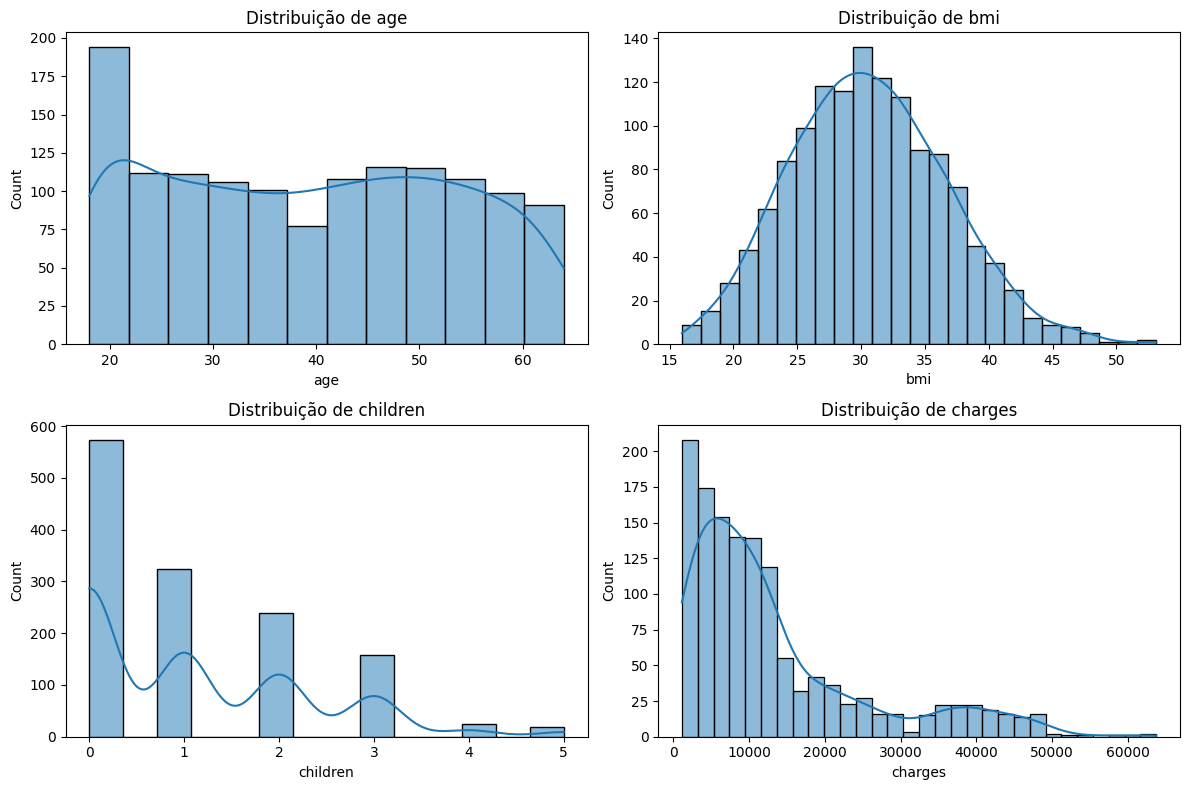

In [7]:
# FEATURES NUMERICAS
num_cols = ['age', 'bmi', 'children', 'charges']

# TAMANHO DA FIGURA
plt.figure(figsize=(12,8))
# ESTRUTURA DE REPETIÇÃO DENTRO DA LISTA DAS FEATURES NUMERICAS PARA EXIBIR EM UMA MATRIZ
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(dados[col], kde=True)
    plt.title(f'Distribuição de {col}')

# EXIBINDO OS GRÁFICOS
plt.tight_layout()
plt.show()


### **OUTLIERS (BOXPLOTS)** ###

Aqui utilizo boxplots para identificar valores extremos, principalmente em:
- 'bmi'
- 'charges'

Essas variáveis são as que tipicamente apresentam maior dispersão

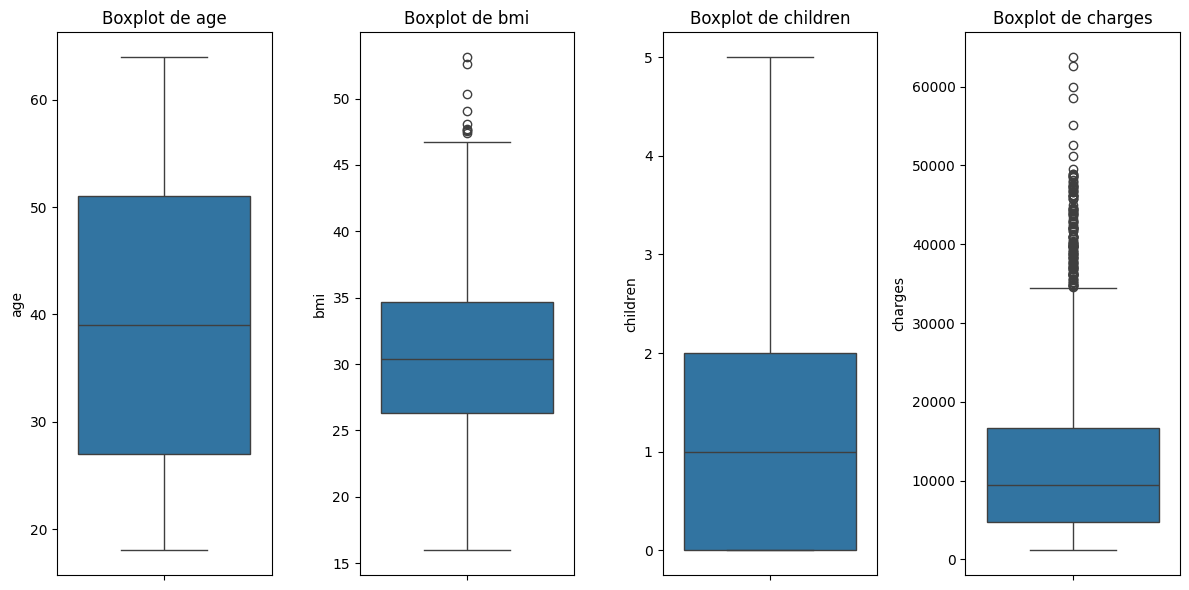

In [10]:
# DEFINE TAMANHO DA FIGURA
plt.figure(figsize=(12,6))
# ESTRUTURA DE REPETIÇÃO PARA PLOTAR AS FIGURAS COMO MATRIZ
for i, coluna in enumerate(num_cols, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=dados[coluna])
    plt.title(f'Boxplot de {coluna}')

# EXBIE AS FIGURAS
plt.tight_layout()
plt.show()


**bmi**

In [11]:
# QUANTIDADE DE OUTLIERS PRESENTE EM BMI 
# Quartis
Q1 = dados['bmi'].quantile(0.25)
Q3 = dados['bmi'].quantile(0.75)
IQR = Q3 - Q1

# Limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtro de outliers
outliers = dados[(dados['bmi'] < limite_inferior) | (dados['bmi'] > limite_superior)]

# Contagem
num_outliers = outliers.shape[0]

print(f"Número de outliers na coluna 'bmi': {num_outliers}")

Número de outliers na coluna 'bmi': 9


**charges**

In [12]:
# QAUNTIDADE DE OUTLIERS PRESENTE NO TARGET
# Quartis
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1

# Limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtro de outliers
outliers = dados[(dados['charges'] < limite_inferior) | (dados['charges'] > limite_superior)]

# Contagem
num_outliers = outliers.shape[0]

print(f"Número de outliers na coluna '{coluna}': {num_outliers}")

Número de outliers na coluna 'charges': 139


### **NORMALIDADE: (HISTPLOT + KDE + Q-Q PLOT)**  ###

Nesta etapa avalio se as variáveis seguem distribuição normal.
Utilizo:

- Histograma + KDE para observar comportamento;
- Gráfico Q-Q (Quantile-Quantile plot) para verificar aderência à normalidade;
- Teste estatístico Shapiro-wilk e Klomogorov Smirnov.

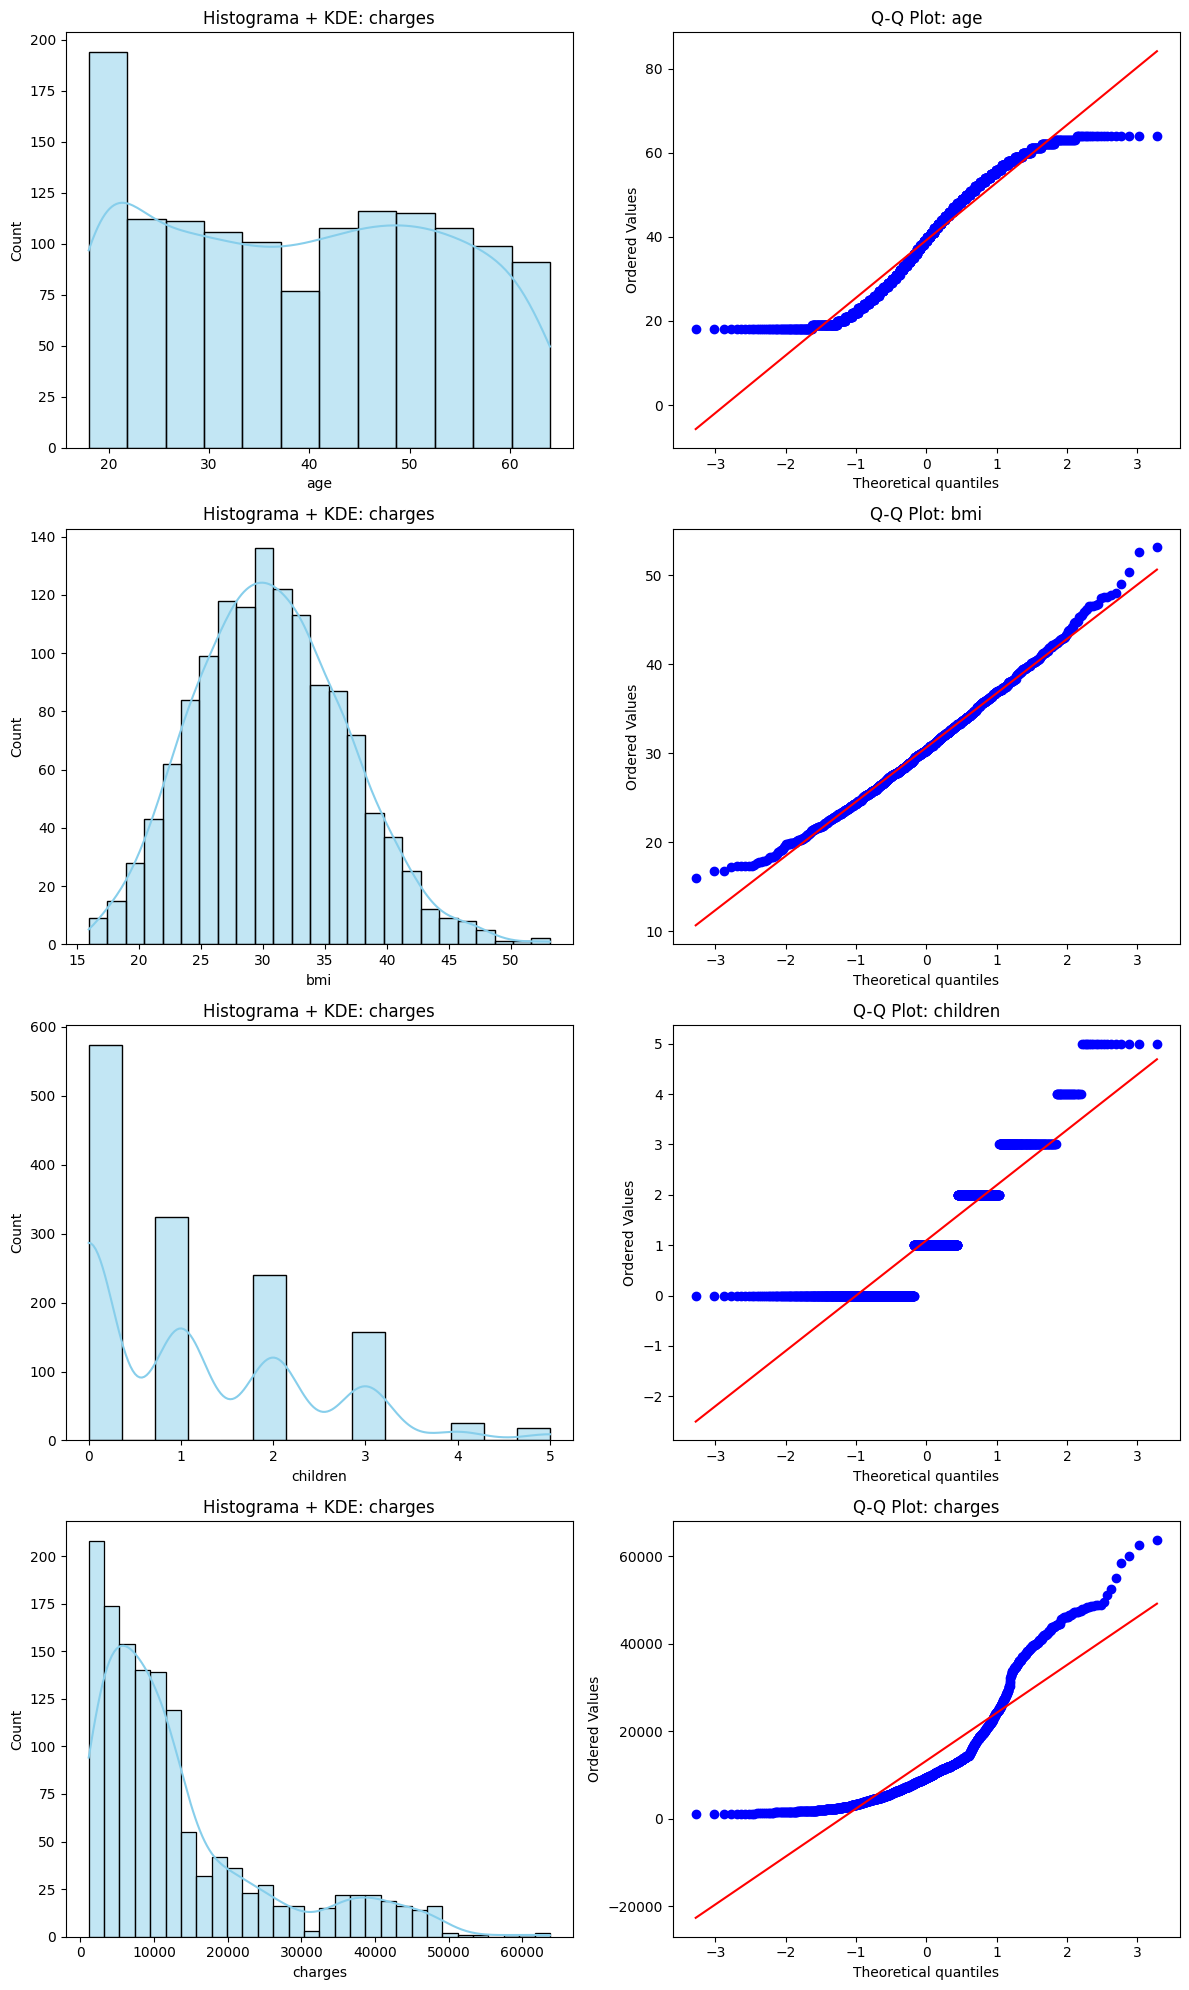

In [15]:
# Seleciona apenas colunas numéricas
numeric_cols = dados.select_dtypes(include=['int64', 'float64']).columns

# Define tamanho da figura e grade de subplots
numero_cols = 2  # 2 gráficos por linha: hist + qq
numero_rows = len(num_cols)  # 1 linha por variável
plt.figure(figsize=(12, 5 * numero_rows))

for i, colunas in enumerate(numeric_cols):
    # Histograma com KDE
    plt.subplot(numero_rows, 2, 2*i + 1)
    sns.histplot(dados[colunas], kde=True, color='skyblue')
    plt.title(f'Histograma + KDE: {col}')
    
    # Q-Q plot
    plt.subplot(numero_rows, 2, 2*i + 2)
    sts.probplot(dados[colunas], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {colunas}')

plt.tight_layout()
plt.show()


**Aplicando testes de normalidade**

teste estatistico de normalidade para cada feature/target

**shapiro-wilk**

In [ ]:
#não segue uma distribuição normal p = 5.69204692845418e-22
sts.shapiro(dados.age)

ShapiroResult(statistic=np.float64(0.9447009637825445), pvalue=np.float64(5.69204692845418e-22))

In [ ]:
#não segue uma distribuição normal p = 2.60468368798344e-05
sts.shapiro(dados.bmi)

ShapiroResult(statistic=np.float64(0.9938864621676107), pvalue=np.float64(2.60468368798344e-05))

In [ ]:
#não segue uma distribuição normal p = 5.066436570900864e-36
sts.shapiro(dados.children)

ShapiroResult(statistic=np.float64(0.823180467362945), pvalue=np.float64(5.066436570900864e-36))

In [ ]:
#não segue uma distribuição normal p = 1.1505226334932036e-36
sts.shapiro(dados.charges)

ShapiroResult(statistic=np.float64(0.8146881157362383), pvalue=np.float64(1.1505226334932036e-36))

**lilliefors (klomogorv smirnov)**

In [ ]:
#distribuição não é normal p = 0.0009999999999998899
lilliefors(dados.age)

(np.float64(0.07894454646849702), np.float64(0.0009999999999998899))

In [ ]:
#distribuição não é normal p = 0.04431273291697496
lilliefors(dados.bmi)

(np.float64(0.026099881197044872), np.float64(0.04431273291697496))

In [ ]:
#distribuição não é normal p = 0.0009999999999998899
lilliefors(dados.children)

(np.float64(0.2471317838278972), np.float64(0.0009999999999998899))

In [ ]:
#distribuição não é normal p = 0.0009999999999998899
lilliefors(dados.charges)

(np.float64(0.18846450965981876), np.float64(0.0009999999999998899))

### **RELAÇÕES BIVARIADAS** ###

Aqui analiso como cada variavel se relaciona com as outras, especialmente com o target 'charges'.

O objetivo é identificar quais variáveis possuem maior poder preditivo.

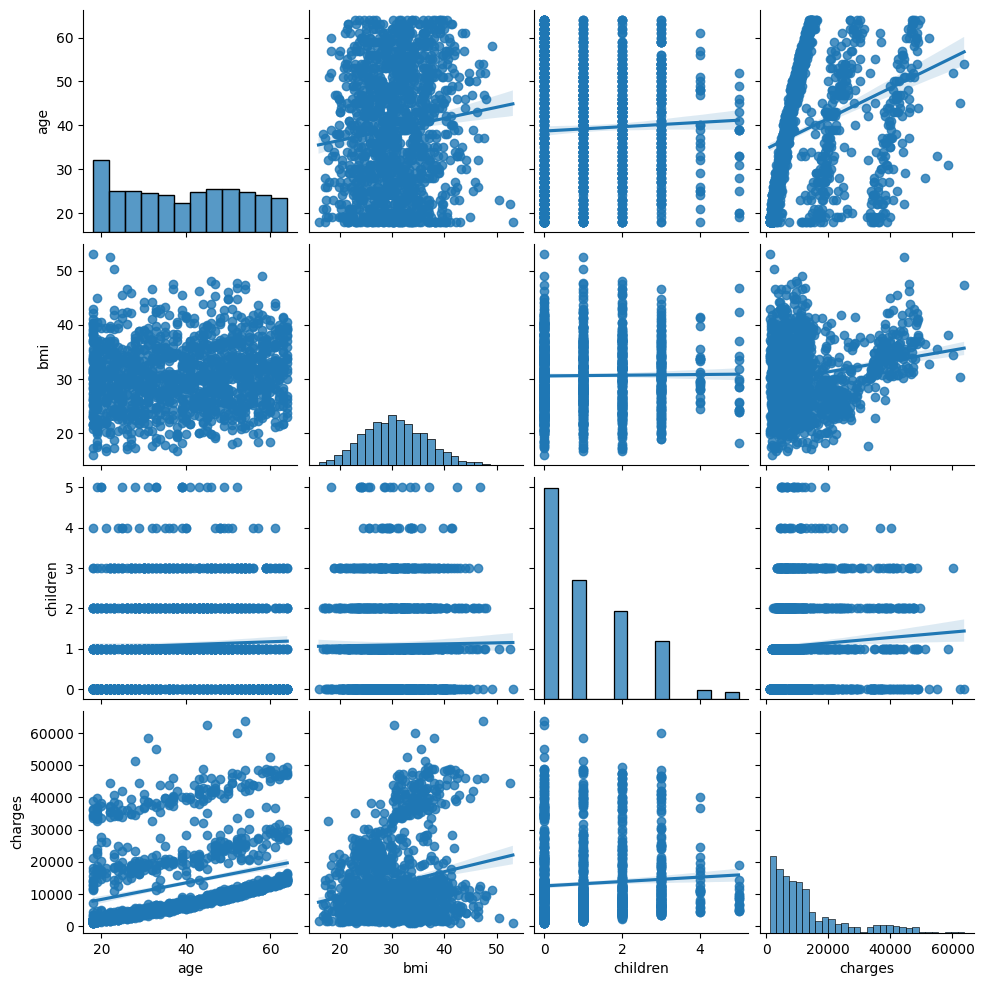

In [16]:
# CRIA UMA MATRIZ COM AS CORRELAÇÕES GRÁFICAS DE CADA VARIAVEL E NA DIAGONA DIREITA, A DISTRIBUIÇÃO ATRAVÉS DO HISPLOT
sns.pairplot(dados[['age', 'bmi', 'children', 'charges']], kind='reg')
plt.show()

In [17]:
# CRIA UMA CÓPIA DO DATASET ORIGINAL
dados_s_encoding = dados.copy()
# ENCODING DA VARIÁVEL BINÁRIA SMOKER
dados_s_encoding['smoker_encoded'] = dados_s_encoding['smoker'].map({'no': 0, 'yes': 1})

# EXIBINDO PARA VALIDAR
dados_s_encoding[['smoker', 'smoker_encoded']].head()


,smoker,smoker_encoded
0,yes,1
1,no,0
2,no,0
3,no,0
4,no,0


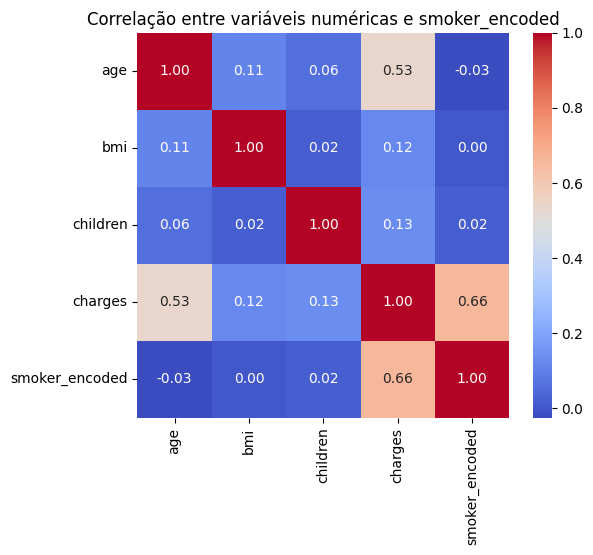

In [22]:
# MATRIZ DE CORRELAÇÃO INCLUI SOMKER_ENCODED
corr = dados_s_encoding[['age', 'bmi', 'children', 'charges', 'smoker_encoded']].corr(method='spearman')
# DEFINE O TAMANHO DA FIGURA E PLOTA O HEATMAP
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlação entre variáveis numéricas e smoker_encoded")
plt.show()


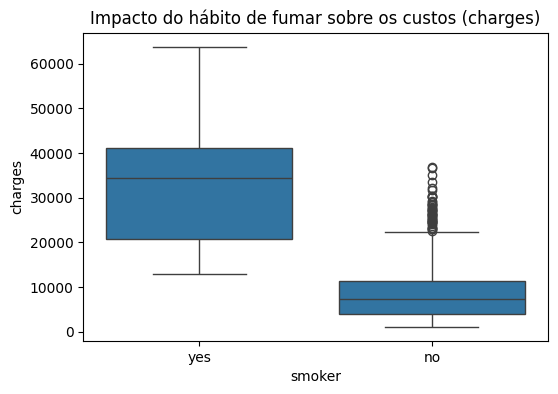

In [25]:
# PLOTA UM BOXPLOT SOBRE A FEATURE SMOKER, VISANDO OBSERVAR OS OUTLIERS ENTRE SUAS DUAS CLASSES OLHANDO PARA OS VALORES DE CHARGES
plt.figure(figsize=(6,4))
sns.boxplot(data=dados_s_encoding, x='smoker', y='charges')
plt.title('Impacto do hábito de fumar sobre os custos (charges)')
plt.show()


### **CONCLUSÃO DA ANÁLISE EXPLORATÓRIA DE DADOS (EDA)**

A EDA permitiu compreender de forma clara o comportamento das variáveis e como elas se relacionam com o custo de seguro de saúde (charges). Verificamos que não há valores ausentes e que o dataset possui variáveis bem definidas, exigindo apenas encoding para as features categoricas.

As analises estatísticas e gráficas mostram forte assimetria no target e ausência de normalidade nas variáveis numéricas, o que indica a presença de relações não lineares nos dados. Os boxplots confirmaram outliers naturais - especialmente charges e bmi - que foram mantidos por refletirem propriedades reais da população.

Na análise das relações bivariadas, alguns pontos se destacam:

- smoker exerce impacto expressivo sobre charges, sendo o fator de maior influência.
- age e bmi apresentam correlações moderadas e claras com o target.
- children, sex e region mostram baixam relevância individual.

De modo geral, a EDA mostrou que os custos têm grande variabilidade e dependem mais fortemente de poucos atributos-chave. Esses achados direcionam as próximas etapas, permitindo definir um pré-processamento mais assertivo e selecionar modelos - lineares e não lineares -  adequados à estrutural real dos dados.

## **PREPARAÇÃO DOS DADOS PARA REGRESSÃO LINEAR SIMPLES E MULTIPLA**

Nesta etapa foram aplicadas técnicas de pré-processamento para preparar o dataset para a Regressão Linear Simples e Múltipla. O objetivo foi transformar variáveis categóricas em valores numéricos, padronizar a estrutura dos dados, garantir consistência e permitir uma análise adequada da relação entre as variáveis.

A preparação descrita abaixo é reutilizada tanto na regressão linear simples quanto na múltipla.

**Criação de uma cópia do Dataset**

Antes de iniciar o pré-processamento, foi criada uma cópia do conjunto original para preservar os dados brutos.

In [8]:
dados_encoding = dados.copy() # CRIA UMA CÓPIA DO DATASET ORIGINAL PARA APLICAR O PRE-PROCESSAMENTO PARA REGRESSÃO SIMPLES

**Seleção de variáveis categóricas e Aplicação de OrdinalEncoding**

As variáveis categóricas (sex, smoker, region) foram transformadas em valores numéricos utilizando OrdinalEncoder, permitindo sua utilização nas regressões.

In [9]:
var_cat = ['sex','smoker','region'] # COLUNAS COM VARIAVEIS CATEGORICAS E BINARIA
encoding_ordi = OrdinalEncoder() # CRIA O OBJETO ENCODADOR

cat_cols = dados_encoding.select_dtypes(include=['object']).columns # SELECIONA SOMENTE AS FEATURES DO TIPO OBJECT
dados_encoding[cat_cols] = encoding_ordi.fit_transform(dados_encoding[cat_cols]) # CONVERTE AS FEATURE CATEGORICAS E BINARIAS ATRAVÉS DO ENCODING
dados_encoding[cat_cols] = dados_encoding[cat_cols].astype(int) # CONVERTE O TIPO NATIVO DAS FEATURES DE FLOAT PARA INT
dados_encoding # PRINTA O DATASET


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


Aqui está a ordem da classes transformadas pelo OrdinalEncoding

In [10]:
# PRINTA A ORDEM DAS CLASSES CODIFICADA PELO ORDINALENCODING()
for coluna, classes in zip(var_cat, encoding_ordi.categories_):
    print(f"{coluna}: {classes}")

sex: ['female' 'male']
smoker: ['no' 'yes']
region: ['northeast' 'northwest' 'southeast' 'southwest']


**Criação de KFold para Validação Cruzada**

Foi configurado um KFold com 15 divisões para avaliação dos modelos de regressão linear e múltipla.

In [11]:
# KFOLD QUE SERÁ UTILIZADO PARA AVALIAR OS MODELOS DE REGRESSÃO LINEAR E MULTIPLAR COM A VALIDAÇÃO CRUZADA VISANDO O COEFICIENTE DE DETERMINAÇÃO.
kfold = KFold(n_splits = 15,shuffle = True,random_state = 10)

**Análise de correlação entre as Variáveis**

Com os dados já codificados, foi calculada a matriz de correlação utilizando o método de Spearman, que é mais robusto para variáveis não linearmente distribuídas.

In [12]:
# MATRIZ DE CORRELAÇÃO
matriz_correlacao = dados_encoding.corr(method='spearman')
matriz_correlacao

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020809,0.107736,0.056992,-0.025210,0.004315,0.534392
sex,-0.020809,1.000000,0.044802,0.015589,0.076185,0.004614,0.009490
bmi,0.107736,0.044802,1.000000,0.015607,0.002203,0.152959,0.119396
children,0.056992,0.015589,0.015607,1.000000,0.016583,0.010604,0.133339
smoker,-0.025210,0.076185,0.002203,0.016583,1.000000,-0.002155,0.663460
region,0.004315,0.004614,0.152959,0.010604,-0.002155,1.000000,-0.043531
charges,0.534392,0.009490,0.119396,0.133339,0.663460,-0.043531,1.000000


A matriz foi plotada em formato heatmap para facilitar a visualização das correlações entre as features e o target

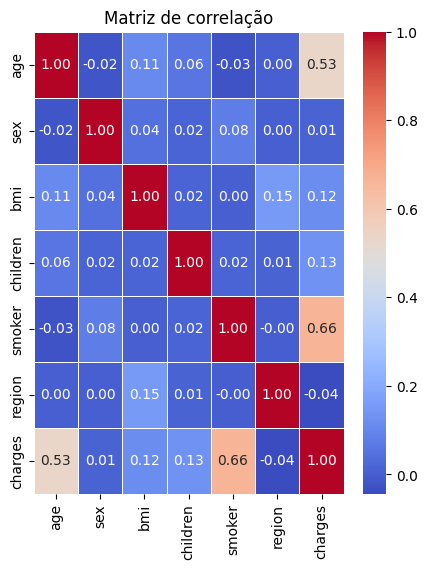

In [13]:
    # PLOTANDO A MATRIZ EM HEATMAP
    plt.figure(figsize=(5,6))
    sns.heatmap(matriz_correlacao, annot = True, cmap = 'coolwarm', fmt ='.2f', linewidths = .5)
    plt.title('Matriz de correlação')
    plt.show()

Essa análise auxiliou na seleção das variáveis mais relevantes para aplicação das regressões.

## **REGRESSÃO LINEAR SIMPLES (charges ~ age)**


### **Objetivo**

Avaliar a relação entre a idade do indivíduo e o custo do seguro médico (charges).
A variável age foi escolhida pois apresenta a segunda maior correlação com o target (≈ 0.53), justificando o teste de um modelo linear simples.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

### **Preparação dos dados**

- age foi utilizada como variável preditora (x)
- chages foi utilizada como variável alvo (y)
- Os dados foram divididos em treino e teste (70%/30%) com random_state = 5

In [24]:
# CAPTURANDO O VALORES DA FEATURE 'AGE'
age_valores = dados.iloc[:, 0:1].values
age_valores

array([[19],
       [18],
       [28],
       ...,
       [18],
       [21],
       [61]], dtype=int64)

In [25]:
# CAPTURANDO OS VALORES DO TARGET 'CHARGES'
charges_valores = dados.iloc[:, 6].values
charges_valores

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

In [26]:
# SEPARANDO OS DADOS EM TREINO E TESTE, COM ESTADO RANDOMICO = 5 E TAMANHO PARA TESTE DE 30% 
x_treino, x_teste, y_treino, y_teste = train_test_split(age_valores, charges_valores, test_size= 0.3, random_state = 5)

In [27]:
# FORMA DO TREINO
x_treino.shape, y_treino.shape

((936, 1), (936,))

In [28]:
# FORMA DO TESTE
x_teste.shape, y_teste.shape

((402, 1), (402,))

### **Treinamento do Modelo**

Foi treinado um modelo de Regressão Linear, utilizando:

- Ajuste dos parâmetros (coeficiente angular e intercepto).
- Cálculo do R² no conjunto de treino.
- Geração das previsões.
- Análise das métricas de erro.

In [29]:
regressor_linear = LinearRegression() # DEFINE O REGRESSOR LINEAR
regressor_linear.fit(x_treino, y_treino) # TREINA O REGRESSOR COM OS DADOS DE TREINO

LinearRegression()

In [30]:
# COEFICIENTE ANGULAR DO MODELO
regressor_linear.coef_

array([252.07288089])

In [31]:
# INTERCEPTO DO MODELO
regressor_linear.intercept_

3563.5191023964708

In [32]:
# COEFICIENTE DE DETERMINAÇÃO: R^2
regressor_linear.score(x_treino, y_treino)

0.0820622585490427

In [33]:
# PREVISOES FEITAS COM OS DADOS DE TREINO
previsoes_treino = regressor_linear.predict(x_treino)
previsoes_treino

array([16167.1631471 , 11125.70552922, 18183.74619425, 17175.45467067,
       19444.11059872, 13394.36145726, 11629.85129101, 16419.23602799,
       18687.89195604, 13394.36145726,  8100.83095849, 17679.60043246,
       13142.28857637,  8352.90383938, 15158.87162352,  8100.83095849,
       18939.96483693, 19192.03771783, 12638.14281458, 18687.89195604,
       16923.38178978, 14654.72586173, 16419.23602799, 13898.50721905,
       17175.45467067, 15410.94450442, 17931.67331336, 18183.74619425,
       16419.23602799, 19696.18347961,  8352.90383938, 17679.60043246,
        9613.26824385,  8604.97672028, 15158.87162352, 12890.21569548,
        8100.83095849,  9865.34112475, 17931.67331336, 15915.0902662 ,
       13898.50721905, 18435.81907514, 16923.38178978, 11629.85129101,
       14654.72586173, 16923.38178978, 15663.01738531, 13142.28857637,
       10621.55976743, 17931.67331336, 15158.87162352, 10369.48688653,
       15410.94450442, 16671.30890889, 16671.30890889,  9361.19536296,
      

### **Metricas de desempenho e validação cruzada (charges x  age) - treino**

As seguinte métricas foram avaliadas:

- MAE - Erro Médio Absoluto.
- MSE - Erro Quadrático Médio.
- RMSE - Raiz do Erro Médio Quadrático.
- R² (TREINO).
- Validação Cruzada (KFold = 15) - para medir a estabilidade do modelo.

Essas métricas permitem avaliar o quão bem a idade explica os custos.

In [34]:
# ERRO MÉDIO ABSOLUTO
mean_absolute_error(y_treino, previsoes_treino)

9246.831052211292

In [35]:
# ERRO MÉDIO QUADRÁTICO
mean_squared_error(y_treino, previsoes_treino)

136007583.82389244

In [36]:
# RAIZ DO ERROR MÉDIO QUADRÁTICO
np.sqrt(mean_squared_error(y_treino, previsoes_treino))

11662.228938924687

In [37]:
# VALIDAÇÃO CRUZADA COM OS DADOS DE TREINO
resultado = cross_val_score(regressor_linear,age_valores, charges_valores,cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 7.09%


### **Visualização da regressão - Treino**

A reta ajustada foi plotada sobre os dados para visualizar a inclunação da relação entre idade e custos.

- A inclinação positiva confirma que quanto maior a idade, maior tende a ser o custo.
- A dispersão alta ao redor da linha ilustra que idade explica apenas parte da variação.

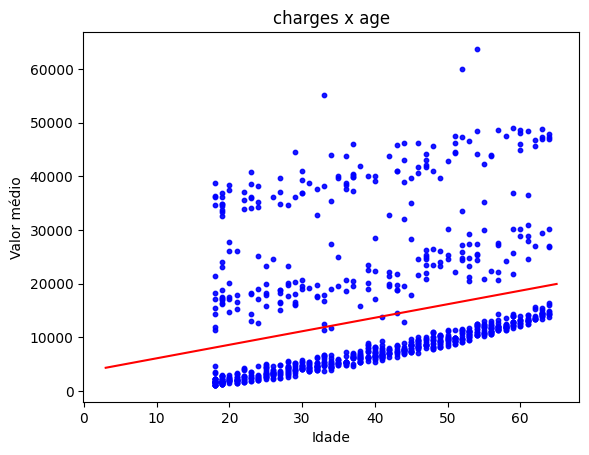

In [38]:
#ajuste da reta em relação aos dados
plt.scatter(y = y_treino, x =  x_treino,color = 'blue', s = 10, alpha = 0.9) #criação do grafico definindo o eixo y e eixo x
x_plot = np.linspace(3,65) #espaçamento do grafico
plt.plot(x_plot, x_plot * regressor_linear.coef_ + regressor_linear.intercept_, color = 'red') #equação montada para a reta ajustada
plt.title('charges x age') #titulo do grafico
plt.ylabel('Valor médio') # titulo eixo y
plt.xlabel('Idade') # titulo eixo x
plt.show() # exibindo o grafico


### **Avaliação do conjunto de teste**

No conjunto de teste:

- Previsões foram geradas.
- Métricas (MAE,MSE, RMSE, R² e validação cruzada) foram calculadas novamente.
- A reta foi visualizada com os dados de teste.

Isso permite verificar a generalização do modelo.

In [39]:
# PREVISOES FEITAS COM OS DADOS DE TESTE
previsoes_teste = regressor_linear.predict(x_teste)
previsoes_teste

array([ 8100.83095849,  9613.26824385, 17175.45467067,  9109.12248206,
       12386.06993369, 14654.72586173, 15410.94450442, 16167.1631471 ,
        9865.34112475, 16923.38178978, 19192.03771783, 17679.60043246,
        8100.83095849, 15663.01738531, 15410.94450442, 12638.14281458,
       14150.58009995, 15915.0902662 , 15915.0902662 , 13142.28857637,
        9109.12248206,  8352.90383938,  8352.90383938, 10873.63264832,
       10369.48688653, 12386.06993369, 17427.52755157, 19696.18347961,
       18939.96483693, 19444.11059872, 14150.58009995,  8352.90383938,
        8857.04960117, 15663.01738531, 15663.01738531,  8100.83095849,
       11881.9241719 ,  8857.04960117, 10117.41400564, 10369.48688653,
        8100.83095849, 19696.18347961, 10621.55976743, 12386.06993369,
       16167.1631471 , 14402.65298084, 16167.1631471 ,  9361.19536296,
       16671.30890889,  8352.90383938,  9361.19536296, 11377.77841011,
       10621.55976743,  9361.19536296,  9613.26824385, 13142.28857637,
      

### **Previsão Individual**

Foi realizado um exemplo real:

- Cliente com 33 anos -> 11881.9241719

Este ponto ilustra a aplicação prática do modelo

In [40]:
# PREVISÃO FEITA PELO MODELO COM UM CLIENTE CONTENDO 33 ANOS
valor_medio = regressor_linear.predict([[33]])
valor_medio

array([11881.9241719])

### **Metricas de desempenho e validação cruzada (charges x  age) - teste**
As seguinte métricas foram avaliadas:

- MAE - Erro Médio Absoluto.
- MSE - Erro Quadrático Médio.
- RMSE - Raiz do Erro Médio Quadrático.
- R² (TREINO).
- Validação Cruzada (KFold = 15) - para medir a estabilidade do modelo.

Essas métricas permitem avaliar o quão bem a idade explica os custos.

In [41]:
# COEFICIENTE DE DETERMINAÇÃO DO TESTE: R^2
regressor_linear.score(x_teste, y_teste)

0.10267650072154177

In [42]:
# ERRO MÉDIO ABSOLUTO
mean_absolute_error(y_teste, previsoes_teste)

8867.840003327274

In [43]:
# ERRO MÉDIO QUADRÁTICO
mean_squared_error(y_teste, previsoes_teste)

127589203.83739154

In [44]:
# RAIZ DO ERROR MÉDIO QUADRÁTICO
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

11295.53911229524

In [45]:
# VALIDAÇÃO CRUZADA TESTE
resultado = cross_val_score(regressor_linear,age_valores, charges_valores,cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 7.09%


### **Visualização da regressão - Teste**

A reta ajustada foi plotada sobre os dados para visualizar a inclunação da relação entre idade e custos.

- A inclinação positiva confirma que quanto maior a idade, maior tende a ser o custo.
- A dispersão alta ao redor da linha ilustra que idade explica apenas parte da variação.

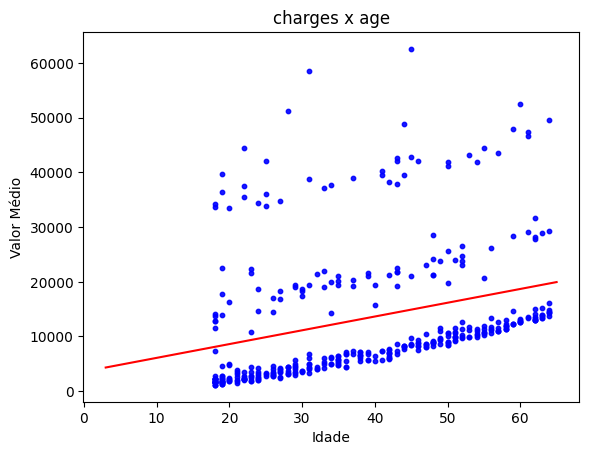

In [46]:
# ajuste da reta em relação aos dados
plt.scatter(y = y_teste, x =  x_teste,color = 'blue', s = 10, alpha = 0.9) #criação do grafico definindo o eixo y e eixo x
x_plot = np.linspace(3,65) #espaçamento do grafico
plt.plot(x_plot, x_plot * regressor_linear.coef_ + regressor_linear.intercept_, color = 'red') #equação montada para regressão contendo o RM e o MEDV
plt.title('charges x age') #titulo do grafico
plt.ylabel('Valor Médio') # titulo eixo y
plt.xlabel('Idade') # titulo eixo x
plt.show() # exibindo o grafico

### **Análise de Resíduos com StatsModels (Diagnóstico do Modelo)**

Nesta etapa, foi feito a avaliação dos residuos criado pelo regressor com age em função de charges. É feito a analise dos residuos, aplicando:

Testes estatistico de normalidade e visualização gráfica com Q-Q PLOT.

Teste estatistico de homocedasticidade e visualização gráfica para observar a separação dos residuos.

Avaliação dos outliers, buscando o limite máximo entre até 3 e o limite minimo até -3.

Sumário do modelo, para verificar as estatisticas geral resultantes.

In [47]:
# CRIANDO O MODELOS E PASSANDO OS VALORES DE CHARGES E AGE
regressor_sts = smf.ols('charges_valores ~ age_valores', data = dados).fit()

In [48]:
# RESIDUOS GERADO PELO AJUSTE DA RETA 
residuos = regressor_sts.resid
residuos

0        8822.309239
1       -6079.339842
2       -5932.656329
3       10313.739188
4       -7546.153603
            ...     
1333    -5451.467639
1334    -5598.911342
1335    -6175.058642
1336    -6570.114998
1337    10254.395555
Length: 1338, dtype: float64

### **Normalidade dos Residuos**

- Teste estatístico: Lilliefors
- Visualização Q-Q Plot

Resultado esperado: Resíduos não seguem normalidade perfeita, já que o dataset te forte variabilidade

In [49]:
# APLICANDO TESTE ESTATISTICO PARA NORMALIDADE DOS RESIDUOS
estatistica_teste, p = lilliefors(residuos)
print('Estatistica do teste:{}, p valor: {}'.format(estatistica_teste, p))

Estatistica do teste:0.35265247538203104, p valor: 0.0009999999999998899


Text(0.5, 1.0, 'Residuos (charges x age)')

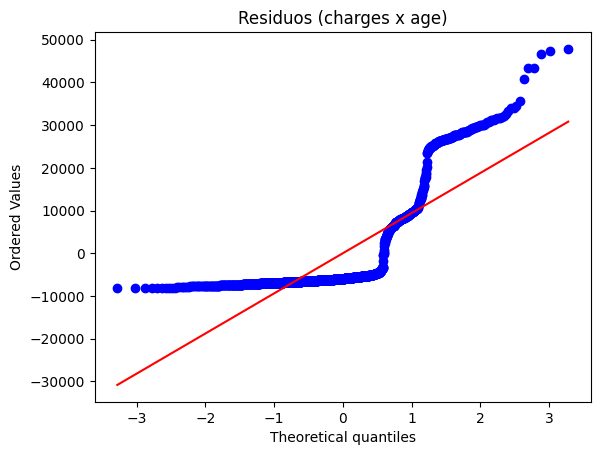

In [50]:
# Q-Q PLOT PARA ANALISE GRÁFICA DE NORMALIDADE
sts.probplot(residuos, dist = 'norm', plot = plt)
plt.title('Residuos (charges x age)')

### **Homocedasticidade**

- Teste Breusch-pagan
- Gráfico dos resíduos vs valores preditos

Ao analisar o gráfico de resíduos, ficou claro que os erros do modelo não se espalham de forma uniforme. Para valores baixos de charges, os resíduos variam muito, enquanto para valores mais altos praticamente não há pontos. Isso mostra que a variância dos erros muda ao longo das previsões.

Mesmo que o teste Breusch-Pagan tenha dado um p-valor alto (0.98), indicando homocedasticidade, esse resultado pode ocorrer porque o modelo tem baixo poder explicativo. Por isso, o gráfico é mais confiável nesse caso.

Conclusão: os resíduos apresentam heterocedasticidade, ou seja, o modelo não mantém a variância constante dos erros.

In [51]:
# APLICANDO TESTE DE HOMOCEDASTICIDADE NOS RESIDUOS
#teste de homocedasticidade p > 0.05 = dados homogenios, p <= 0.05 =  dados não homogenios (grande variancia)
estatistica, p, f, fp = sms.het_breuschpagan(regressor_sts.resid, regressor_sts.model.exog)
print('estatistica do teste: {}'.format(estatistica))
print('p_valor: {}'.format(p))
print('f_valor: {}'.format(f))
print('fp_valor: {}'.format(fp))

estatistica do teste: 0.0004134966684701258
p_valor: 0.9837764407271117
f_valor: 0.00041287871432965233
fp_valor: 0.9837916004454368


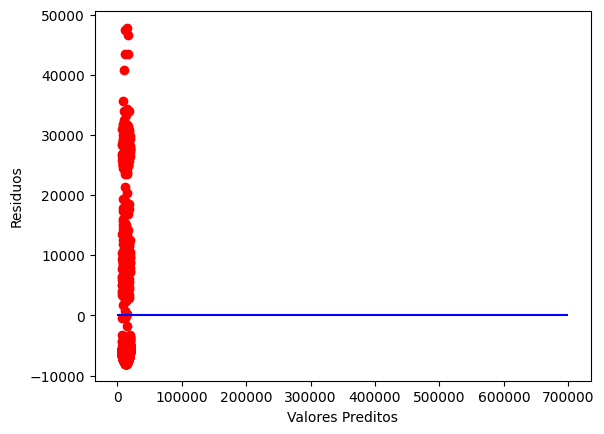

In [52]:
# ANALISE GRÁFICA DA HOMOCEDASTICIDADE DOS RESIDUOS
plt.scatter(y = residuos, x = regressor_sts.predict(), color = 'red')
plt.hlines(y = 0, xmin = 0, xmax = 700000, color = 'blue')
plt.ylabel('Residuos')
plt.xlabel('Valores Preditos')
plt.show()

### **Detecção de outliers**

- Estatística de outliers pelo metodo outliers_test()
- Avaliação dos limites ±3

Resultado esperado: presença de outliers, o que é normal neste dataset e não compromete o modelo simples

In [53]:
# ESTATISTICA DOS OUTLIERS DO RESIDUO
outliers = regressor_sts.outlier_test()
print('Outliers maximo: {}, Outliers minimo: {}'.format(outliers.max(), outliers.min()))

Outliers maximo: student_resid    4.164437
unadj_p          0.999514
bonf(p)          1.000000
dtype: float64, Outliers minimo: student_resid   -0.697265
unadj_p          0.000033
bonf(p)          0.044441
dtype: float64


### **Sumário Estatístico do modelo (StatsModels)**

Fornece:

- coeficiente angular e intercepto
- significância estatística (p-values)
- R² Ajustado
- Análise ANOVA do modelo

In [54]:
# SUMARIO CONTENDO AS ESTATISTICA GERAL DO MODELO
print(regressor_sts.summary())

                            OLS Regression Results                            
Dep. Variable:        charges_valores   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     131.2
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           4.89e-29
Time:                        16:54:45   Log-Likelihood:                -14415.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3165.8850    937.149      3.378      

### **Conclusão da regressão charges ~ age**

A regressão linear entre idade e custo de seguro indica que:

- Existe uma relação linear positiva entre as variáveis.
- O aumento da idade está associado a um aumento no custo do plano.
- No entanto R² é muito baixo, mostrando que a idade sozinha não é o suficiente para prever os custos com alta precisão.

Análise residual indica:

- Resíduos não normalmente distribuidos.
- heterocedasticidade
- presença de outliers: o que reduz a capacidade do modelo em capturar toda a complexidade dos dados

Mesmo assim, o modelo cumpre o seu papel como análise inicial, ajudando a entender o comportamento da variável idade antes da regressão múltipla, onde outras variáveis importantes entram na equação.

## **REGRESSÃO LINEAR SIMPLES (charges ~ smoker)**


### **Objetivo**

Avaliar a relação entre se o indivíduo é adepto a prática de tabagismo e o custo do seguro médico (charges). A variável smoker foi escolhida pois apresenta a maior correlação com o target (≈ 0.66), justificando o teste de um modelo linear simples.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

### **Preparação dos Dados**

- smoker foi utilizada como variável preditora (x)
- chages foi utilizava como variável alvo (y)
- Os dados foram divididos em treino e teste (70%/30%) com random_state = 5

In [39]:
# CHAMA O DATASET UTILIZADO NO PRE-PROCESSAMENTO PARA REGRESSÃO ANTERIOR
dados_encoding

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [40]:
# CAPTURA OS VALORES DE SMOKER
smoker_valores = dados_encoding.iloc[:, 4:5].values
smoker_valores

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [48]:
# CAPTURA O VALOR DO TARGET
charges_valores =  dados_encoding.iloc[:, 6:7]
charges_valores

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
...,...
1333,10600.54830
1334,2205.98080
1335,1629.83350
1336,2007.94500


In [49]:
# SEPARA EM TREINO E TESTE, COM ESTADO RANDOMICO = 5 E TAMANHO DO TESTE COM 30%
x_treino, x_teste, y_treino, y_teste = train_test_split(smoker_valores, charges_valores,test_size = 0.3,random_state = 5)

In [50]:
# FORMA DO TREINO
x_treino.shape, y_treino.shape

((936, 1), (936, 1))

In [51]:
# FORMA DO TESTE
x_teste.shape, y_teste.shape

((402, 1), (402, 1))

### **Treinamento do Modelo**
Foi treinado um modelo de Regressão Linear, utilizando:

- Ajuste dos parâmetros (coeficiente angular e intercepto).
- Cálculo do R² no conjunto de treino.
- Geração das previsões.
- Análise das métricas de erro.

In [52]:
regressor_linear = LinearRegression() # CRIA O REGRESSOR LINEAR DE CHARGES EM FUNÇÃO DE SMOKER
regressor_linear.fit(x_treino, y_treino) # TREINA O MODELO.

LinearRegression()

In [53]:
# INTERCEPTO DO MODELO
regressor_linear.intercept_

array([8721.77590406])

In [54]:
# COEFICIENTE ANGULAR
regressor_linear.coef_

array([[23748.31664362]])

In [55]:
# COEFICIENTE DE DETERMINAÇÃO DO TREINO: R^2
regressor_linear.score(x_treino, y_treino)

0.6158238346847231

In [56]:
# PREVISOES COM OS DADOS DE TREINO
previsoes_treino = regressor_linear.predict(x_treino)
previsoes_treino

array([[ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [32470.09254768],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [32470.09254768],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [32470.09254768],
       [32470.09254768],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [32470.09254768],
       [ 8721.77590406],
       [32470.09254768],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],
       [ 8721.77590406],


### **Metricas de desempenho e validação cruzada (charges ~ smoker) - treino**
As seguinte métricas foram avaliadas:

- MAE - Erro Médio Absoluto.
- MSE - Erro Quadrático Médio.
- RMSE - Raiz do Erro Médio Quadrático.
- R² (TREINO).
- Validação Cruzada (KFold = 15) - para medir a estabilidade do modelo.
- 
Essas métricas permitem avaliar o quão bem a tabagismo explica os custos.

In [57]:
# COEFICIENTE DE DETERMINAÇÃO: R²
regressor_linear.score(x_treino, y_treino)

0.6158238346847231

In [58]:
# ERROR MÉDIO ABOLUSTO DO TREINO
mean_absolute_error(y_treino,previsoes_treino)

5695.107321626328

In [59]:
# ERROR MÉDIO QUADRÁTICO MÉDIO DO TREINO
mean_squared_error(y_treino, previsoes_treino)

56922021.66637975

In [60]:
# RAIZ QUADRADA DO ERROR MÉDIO DO TREINO
np.sqrt(mean_squared_error(y_treino, previsoes_treino))

7544.668426536699

In [61]:
# VALIDAÇÃO CRUZADA TREINO
resultado = cross_val_score(regressor_linear, smoker_valores, charges_valores, cv = kfold)
print('Coeficiente de determninção médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determninção médio: 59.85%


### **Visualização da regressão - Treino**

- A reta ajustada foi plotada sobre os dados para visualizar a inclinação da relação entre fumante e custos.
- A inclinação positiva confirma que se for positivo para tabagismo, maior tende a ser o custo.

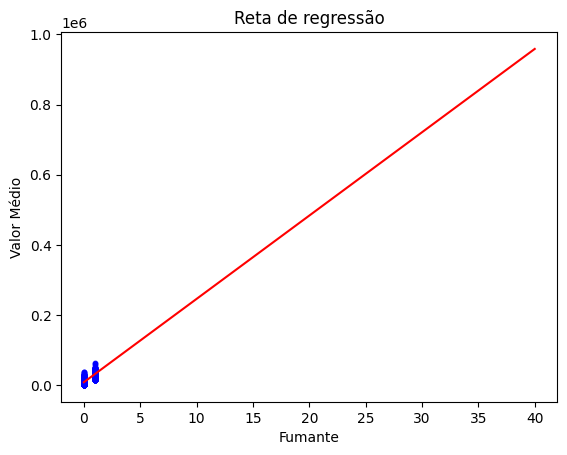

In [128]:
plt.scatter(y = y_treino, x =  x_treino,color = 'blue', s = 10, alpha = 0.9) #criação do grafico definindo o eixo y e eixo x
x_plot = np.linspace(0,40) #espaçamento do grafico
plt.plot(x_plot, x_plot * regressor_linear.coef_ + regressor_linear.intercept_, color = 'red') #equação montada para a reta ajustada
plt.title('Reta de regressão') #titulo do grafico
plt.ylabel('Valor Médio') # titulo eixo y
plt.xlabel('Fumante') # titulo eixo x
plt.show() # exibindo o grafico

### **Avaliação do conjunto de teste**
No conjunto de teste:

- Previsões foram geradas.
- Métricas (MAE,MSE, RMSE, R² e validação cruzada) foram calculadas novamente.
- A reta foi visualizada com os dados de teste.
- Isso permite verificar a generalização do modelo.

In [129]:
# PREVISOES FEITAS COM DADOS DE TESTE
previsoes_teste = regressor_linear.predict(x_teste)
previsoes_teste

array([ 8721.77590406, 32470.09254768,  8721.77590406,  8721.77590406,
        8721.77590406, 32470.09254768,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
       32470.09254768,  8721.77590406,  8721.77590406,  8721.77590406,
       32470.09254768,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406, 32470.09254768,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406, 32470.09254768,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406, 32470.09254768, 32470.09254768, 32470.09254768,
        8721.77590406,  8721.77590406, 32470.09254768,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406, 32470.09254768,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
      

### **Metricas de desempenho e validação cruzada (charges ~smoker) - teste**
As seguinte métricas foram avaliadas:

- MAE - Erro Médio Absoluto.
- MSE - Erro Quadrático Médio.
- RMSE - Raiz do Erro Médio Quadrático.
- R² (TREINO).
- Validação Cruzada (KFold = 15) - para medir a estabilidade do modelo.

Essas métricas permitem avaliar o quão bem o tabagismo explica os custos.

In [131]:
# COEFICIENTE DE DETERMINAÇÃO DO TESTE: R^2
regressor_linear.score(x_teste, y_teste)

0.6254090050905078

In [132]:
# ERROR MÉDIO ABOLUSTO DO TREINO
mean_absolute_error(y_teste,previsoes_teste)

5679.058587380427

In [133]:
# ERROR MÉDIO QUADRÁTICO MÉDIO DO TREINO
mean_squared_error(y_teste, previsoes_teste)

53262582.38371076

In [134]:
# RAIZ QUADRADA DO ERROR MÉDIO DO TREINO
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

7298.1218394673815

In [135]:
#validação cruzada
resultado = cross_val_score(regressor_linear, smoker_valores, charges_valores, cv = kfold)
print('Coeficiente de determninção médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determninção médio: 59.85%


### **Visualização da regressão - Teste**

A reta ajustada foi plotada sobre os dados para visualizar a inclunação da relação entre idade e custos.

- A inclinação positiva confirma que se é fumante, maior tende a ser o custo.

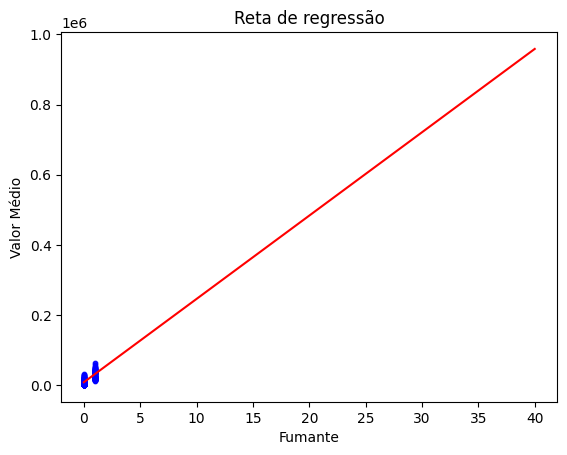

In [136]:
plt.scatter(y = y_teste, x =  x_teste,color = 'blue', s = 10, alpha = 0.9) #criação do grafico definindo o eixo y e eixo x
x_plot = np.linspace(0,40) #espaçamento do grafico
plt.plot(x_plot, x_plot * regressor_linear.coef_ + regressor_linear.intercept_, color = 'red') #equação montada para a reta ajustada
plt.title('Reta de regressão') #titulo do grafico
plt.ylabel('Valor Médio') # titulo eixo y
plt.xlabel('Fumante') # titulo eixo x
plt.show() # exibindo o grafico

### **Previsão Individual**
Foi realizado um exemplo real:

- 0 = não é fumante, 1 = é fumante

- individuo não é fumante: 0 -> 8721.77590406

Este ponto ilustra a aplicação prática do modelo

In [130]:
# VALORES REAIS PREVISTOS COM AS ENTRADAS DE: É FUMANTE, NÃO É FUMANTE = 0, É FUMANTE = 1
valores_previstos = regressor_linear.predict([[0]])
valores_previstos

array([8721.77590406])

### **Análise de Resíduos com StatsModels (Diagnóstico do Modelo)**
Nesta etapa, foi feito a avaliação dos residuos criado pelo regressor com smoker em função de charges. É feito a analise dos residuos, aplicando:

- Testes estatistico de normalidade e visualização gráfica com Q-Q PLOT.
- Teste estatistico de homocedasticidade e visualização gráfica para observar a separação dos residuos.
- Avaliação dos outliers, buscando o limite máximo entre até 3 e o limite minimo até -3.
- Sumário do modelo, para verificar as estatisticas geral resultantes.

In [137]:
# CRIANDO O REGRESSOR
regressor_sts = smf.ols('charges_valores ~ smoker_valores', data = dados_encoding).fit()

In [138]:
# RESIDUOS GERADOS
residuos = regressor_sts.resid
residuos

0      -15165.307832
1       -6708.715998
2       -3984.806298
3       13550.202312
4       -4567.413098
            ...     
1333     2166.280002
1334    -6228.287498
1335    -6804.434798
1336    -6426.323298
1337    -2908.871532
Length: 1338, dtype: float64

### **Normalidade dos Residuos**
- Teste estatístico: Lilliefors
- Visualização Q-Q Plot


Resultado esperado: Resíduos não seguem normalidade perfeita, já que o dataset tem forte variabilidade

In [139]:
# APLICANDO O TESTE DE NORMALIDADE NOS RESIDUOS
estatistica, p = lilliefors(residuos)
print('estatistica do teste: {}'.format(estatistica))
print("valor p: {}".format(p))

estatistica do teste: 0.0867502672927326
valor p: 0.0009999999999998899


Text(0.5, 1.0, 'Q-Q PLOT dos residuos')

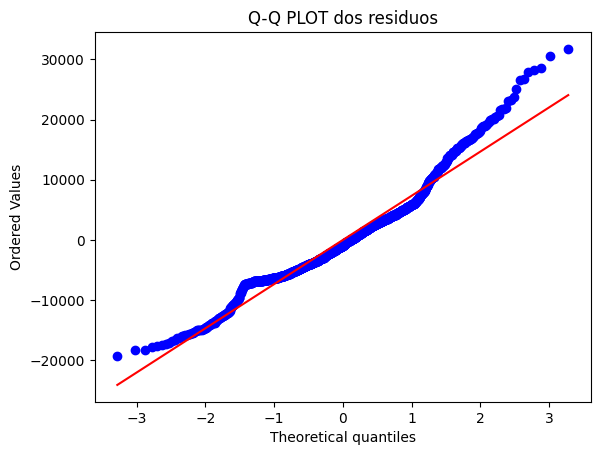

In [140]:
# Q-Q PLOT PARA ANALISE GRÁFICA DOS REISDUOS
sts.probplot(residuos, dist = 'norm', plot = plt)
plt.title('Q-Q PLOT dos residuos')

### **Homocedasticidade**

- Teste Breusch-pagan
- Gráfico dos resíduos vs valores preditos

Ao analisar o gráfico de resíduos, ficou claro que os erros do modelo não se espalham de forma uniforme, e sim em formato de cones verticais indicando heterocedasticidade.

O teste Breusch-pagan, tabmém acusa com o p-valor extremamente baixo: p_valor = 2.8267826039448586e-45

Conclusão: os resíduos apresentam heterocedasticidade, ou seja, o modelo não mantém a variância constante dos erros

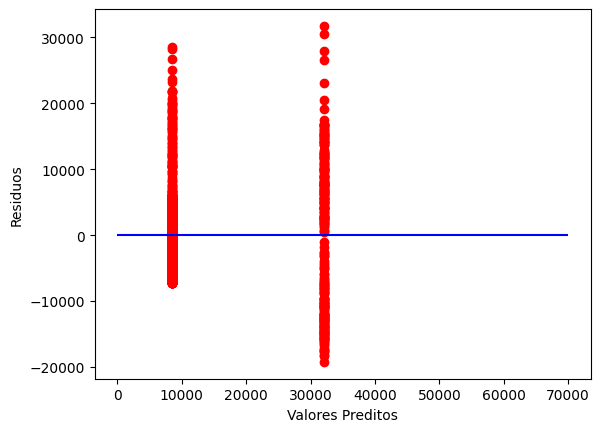

In [141]:
# HOMOCEDASTICIDADE DOS RESIDUOS
plt.scatter(y = residuos, x = regressor_sts.predict(), color = 'red')
plt.hlines(y = 0, xmin = 0, xmax = 70000, color = 'blue')
plt.ylabel('Residuos')
plt.xlabel('Valores Preditos')
plt.show()

In [142]:
# TESE DE HOMOCEDASTICIDADE: P >= 0.05 DADOS HOMOGENEOS, P < 0.05 DADOS NÃOA HOMOGENEOS
estatistica, p, f, fp = sms.het_breuschpagan(regressor_sts.resid, regressor_sts.model.exog)
print('estatistica do teste: {}'.format(estatistica))
print('p_valor: {}'.format(p))
print('f_valor: {}'.format(f))
print('fp_valor: {}'.format(fp))

estatistica do teste: 199.3975890861486
p_valor: 2.8267826039448586e-45
f_valor: 233.96681446097028
fp_valor: 8.597416429752563e-49


### **Detecção de outliers**

- Estatística de outliers pelo metodo outliers_test()
- Avaliação dos limites ±3

Resultado esperado: presença de outliers, o que é normal neste dataset e não compromete o modelo simples

In [143]:
# ANALISANDO OS STUDENT_RESID DOS OUTLIERS
outliers = regressor_sts.outlier_test()
print(f'Outliers minimo: {outliers.min()}, outlier maximo: {outliers.max()}')

Outliers minimo: student_resid   -2.583163
unadj_p          0.000020
bonf(p)          0.026614
dtype: float64, outlier maximo: student_resid    4.281495
unadj_p          0.999338
bonf(p)          1.000000
dtype: float64


### **Sumário Estatístico do modelo (StatsModels)**

Fornece:

- coeficiente angular e intercepto
- significância estatística (p-values)
- R² Ajustado
- Análise ANOVA do modelo

In [144]:
# ESTATISTICA GERAL DO REGRESSOR
print(regressor_sts.summary())

                            OLS Regression Results                            
Dep. Variable:        charges_valores   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2178.
Date:                Wed, 19 Nov 2025   Prob (F-statistic):          8.27e-283
Time:                        18:25:54   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1336   BIC:                         2.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       8434.2683    229.014     36.

### **Conclusão da regressão charges ~ smoker**
A regressão linear entre fumante e custo de seguro indica que:

- Existe uma relação linear positiva entre as variáveis.
- A relação com o tabagismo está associado a um aumento no custo do plano.
- No entanto R² é moderado (62.5%), indicando que fumante sozinho, tem um poder explicativo até que moderado para prever os custos com alta precisão.

Análise residual indica:

- Resíduos não normalmente distribuidos.

- Heterocedasticidade

- Presença de outliers: o que reduz a capacidade do modelo em capturar toda a complexidade dos dados

Mesmo assim, o modelo cumpre o seu papel como análise inicial, ajudando a entender o comportamento da variável fumante antes da regressão múltipla, onde outras variáveis importantes entram na equação.

## **REGRESSÃO LINEAR MULTIPLA**


### **Objetivo**

A regressão linear múltipla tem como objetivo avaliar a relação conjunta entre todas as variáveis preditoras do dataset (age, sex, bmi, children, smoker, region) e o valor do seguro médico (charges).

Após observar que variáveis isoladas — especialmente smoker (66% de correlação) e age (0.53% de correlação) — explicam parte dos custos, mas ainda deixam grande parte da variabilidade sem explicação, apliquei a regressão múltipla para verificar se a combinação de todas as features melhora o desempenho do modelo.

Documentação utilizada:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

### **Preparação dos Dados**

- Todas as features (age, sex, bmi, children, smoker, region) foram utilizadas como variável preditora (x)
- chages foi utilizada como variável alvo (y)
- Os dados foram divididos em treino e teste (70%/30%) com random_state = 5

In [62]:
# FEATURES
independentes = dados_encoding.iloc[:, 0:6].values
independentes

array([[19.  ,  0.  , 27.9 ,  0.  ,  1.  ,  3.  ],
       [18.  ,  1.  , 33.77,  1.  ,  0.  ,  2.  ],
       [28.  ,  1.  , 33.  ,  3.  ,  0.  ,  2.  ],
       ...,
       [18.  ,  0.  , 36.85,  0.  ,  0.  ,  2.  ],
       [21.  ,  0.  , 25.8 ,  0.  ,  0.  ,  3.  ],
       [61.  ,  0.  , 29.07,  0.  ,  1.  ,  1.  ]])

In [63]:
# TARGET
dependente = dados_encoding.iloc[:, 6].values
dependente

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

In [64]:
# DIVISÃO ENTRE TREINO E TESTE, RANDOMICO = 5 E TAMANHO DO TESTE = 30%
x_treino, x_teste, y_treino, y_teste = train_test_split(independentes,dependente,test_size= 0.3,random_state = 5)

In [65]:
# CORPO DO TREINO
x_treino.shape, y_treino.shape

((936, 6), (936,))

In [66]:
# CORPO DO TESTE
x_teste.shape, y_teste.shape

((402, 6), (402,))

In [68]:
dados_encoding.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


### **Treinamento do Modelo**
Foi treinado um modelo de Regressão Linear, utilizando:

- Ajuste dos parâmetros (coeficiente angular e intercepto).
- Cálculo do R² no conjunto de treino.
- Geração das previsões.
- Análise das métricas de erro.

In [69]:
multipla = LinearRegression() # CRIA O MODELO
multipla.fit(x_treino, y_treino) # TREINA O MODELO

LinearRegression()

In [70]:
# PREVISÕES COM OS DADOS DE TREINO
previsoes_treino = multipla.predict(x_treino)
previsoes_treino

array([ 1.26902954e+04,  4.16433232e+03,  1.44723856e+04,  1.30218787e+04,
        1.58967436e+04,  7.67926242e+03,  4.27643416e+03,  1.38581218e+04,
        1.43936752e+04,  8.67806299e+03,  3.81211409e+03,  1.52324944e+04,
        9.52630982e+03,  4.21639422e+03,  1.11451622e+04,  5.62824359e+03,
        3.74045771e+04,  1.35924835e+04,  6.71534331e+03,  1.11987773e+04,
        1.45970239e+04,  3.61847095e+04,  8.53263145e+03,  9.78031093e+03,
        1.27448264e+04,  3.75301380e+04,  3.62346694e+04,  1.32160224e+04,
        7.28659059e+03,  1.49288553e+04,  3.90931439e+03,  1.59194002e+04,
        3.24703708e+03,  2.36478524e+04,  9.91836074e+03,  3.42142759e+04,
        5.34628811e+03,  2.41044102e+03,  1.15097415e+04,  1.16989439e+04,
        6.65145296e+03,  1.50849043e+04,  1.22280311e+04,  9.12227859e+03,
        7.51390648e+03,  3.35187225e+04,  1.45299027e+04,  9.86264872e+03,
        5.64453389e+03,  1.31931791e+04,  7.97814025e+03,  3.04904872e+04,
        7.99859968e+03,  

In [71]:
# INTERCEPTO DO MODELO
multipla.intercept_

-11767.650235464476

In [72]:
# CADA VALOR REPRESENTA O COEFICIENTE ANGULAR DE SUA FEATURE, SEGUIDNO A ORDEM DE COLUNAS DO DATASET
multipla.coef_

array([  260.1633228 ,  -308.27530049,   328.66308298,   602.34159086,
       24031.92915306,  -328.18271651])

In [74]:
#COEFICIENTE DE DETERMINAÇÃO DO TREINO
multipla.score(x_treino, y_treino)

0.7468954747900357

### **Metricas de desempenho e validação cruzada (Multipla) - treino**
As seguinte métricas foram avaliadas:

- MAE - Erro Médio Absoluto.
- MSE - Erro Quadrático Médio.
- RMSE - Raiz do Erro Médio Quadrático.
- R² (TREINO).
- Validação Cruzada (KFold = 15) - para medir a estabilidade do modelo.

Essas métricas permitem avaliar o quão bem a todas as features explica o target: charges.

In [75]:
# ERRO MEDIO ABSOLUTO - TREINO
mean_absolute_error(y_treino, previsoes_treino)

4260.849838478161

In [76]:
# ERRO MEDIO QUADRATICO - TREINO
mean_squared_error(y_treino, previsoes_treino)

37501601.00649909

In [77]:
# RAIZ DO ERRO MÉDIO QUADRATICO - TREINO
np.sqrt(mean_squared_error(y_treino, previsoes_treino))

6123.855077195989

In [78]:
# COEFICIENTE DE DETERMINAÇÃO DO TREINO: R^2
multipla.score(x_treino, y_treino)

0.7468954747900357

In [79]:
# VALIDAÇÃOA CRUZADA - TREINO
resultado = cross_val_score(multipla, independentes, dependente, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 73.73%


### **Avaliação do conjunto de teste**
No conjunto de teste:

- Previsões foram geradas.
- Métricas (MAE,MSE, RMSE, R² e validação cruzada) foram calculadas novamente.

In [88]:
# PREVISÕES TESTE
previsoes_teste = multipla.predict(x_teste)
previsoes_teste

array([ 2812.9783187 , 28003.9431294 , 11641.21899878,  4803.26570367,
        8527.60628887, 35564.01662571, 11667.14768055, 11537.86884315,
        8528.98467807, 10876.33769211, 15361.65163122, 11017.09759765,
        5129.37047119,  9155.79306485,  8453.11211396,  9154.14178028,
       32174.30151291, 12682.126851  , 13491.86473327,  7681.89657901,
       29333.66019259,  1911.04284324,  2869.85089652,  3995.29193048,
        2831.00579376,  9383.29325355, 37485.83675916, 17126.17026189,
       10705.6341586 , 14089.57698985, 13343.55281684,   813.08799459,
        5625.21948895, 11018.16438135, 31813.43016461,  4206.49520554,
        6409.40952464,  2624.3779738 ,  6457.00862721,  5912.90477914,
        3394.02939308, 37422.6558459 , 30821.70631707, 30252.59539938,
       10741.41046681,  7666.19739417, 35423.87237266,  3129.92936564,
       19481.18420036,  4868.12244101, 10411.85316653, 29162.1476943 ,
        3813.17999727,  4208.90501073,   874.16220328,  7572.75517915,
      

### **Metricas de desempenho e validação cruzada (multipla) - teste**
As seguinte métricas foram avaliadas:

- MAE - Erro Médio Absoluto.
- MSE - Erro Quadrático Médio.
- RMSE - Raiz do Erro Médio Quadrático.
- R² (TESTE).
- Validação Cruzada (KFold = 15) - para medir a estabilidade do modelo.

Essas métricas permitem avaliar o quão bem o tabagismo explica os custos.

In [89]:
# COEFICIENTE DE DETERMINAÇÃO: R^2
multipla.score(x_teste, y_teste)

0.7574825064531082

In [90]:
#erro medio absoluto
mean_absolute_error(y_teste, previsoes_teste)

4063.431146186927

In [91]:
#erro medio quadratico
mean_squared_error(y_teste, previsoes_teste)

34483231.457962215

In [92]:
#RMSE raiz do erro medio quadratico
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

5872.242455652033

In [93]:
#validação cruzada
resultado = cross_val_score(multipla, independentes, dependente, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 73.73%


### **Previsão Individual**
Foi realizado um exemplo real:

age = 25, 0 = female, 1 = male, bmi = 23.00, children = 0, 0 = não é fumante, 1 = é fumante, 0 = soutwest, 1 = southeast, 2 = northeast, 3 = nortwest

custo: 25999.43017946l

Este ponto ilustra a aplicação prática do modelo

In [94]:
 #previsão de valor médio com registros externos
 valor_medio = multipla.predict([[25,0,23.00,0,1,1]])
 valor_medio

array([25999.43017946])

### **Análise de Resíduos com StatsModels (Diagnóstico do Modelo)**
Nesta etapa, foi feito a avaliação dos residuos criado pelo regressor multiplo. É feito a analise dos residuos, aplicando:

- Testes estatistico de normalidade e visualização gráfica com Q-Q PLOT.
- Teste estatistico de homocedasticidade e visualização gráfica para observar a separação dos residuos.
- Avaliação dos outliers, buscando o limite máximo entre até 3 e o limite minimo até -3.
- Verificando ausência de multicolinearidade
- Comparando as previsões reais x as previsões feitas pelo modelo de regressão linear multipla
- Ajuste da reta valores previstos x valores reais
- Sumário do modelo, para verificar as estatisticas geral resultantes

In [95]:
# CRIANDO O MODELO COM STATSMODELS
multipla_sts = smf.ols('charges ~ age + sex + bmi + children + smoker + region', data = dados_encoding).fit()

In [96]:
# RESIDUOS OBTIDOS
residuos = multipla_sts.resid
residuos

0       -8226.317864
1       -1962.052873
2       -2513.683707
3       18243.162205
4       -1670.785697
            ...     
1333    -1701.457702
1334    -1225.390847
1335    -2733.828866
1336      900.958387
1337    -7872.367796
Length: 1338, dtype: float64

### **Normalidade dos Residuos**
- Teste estatístico: Lilliefors
- Visualização Q-Q Plot

A análise gráfica acusa não normalidade nos residuos e o p-valor comprova essa afirmação

In [97]:
# APLICANDO KLOMOGORV SMIRNOV PARA TESTAR A NORMALIDADE DOS RESIDUOS
estatistica, p = lilliefors(residuos)
print('P valor: {}'.format(p))

P valor: 0.0009999999999998899


Text(0.5, 1.0, 'Q-Q plot residuos')

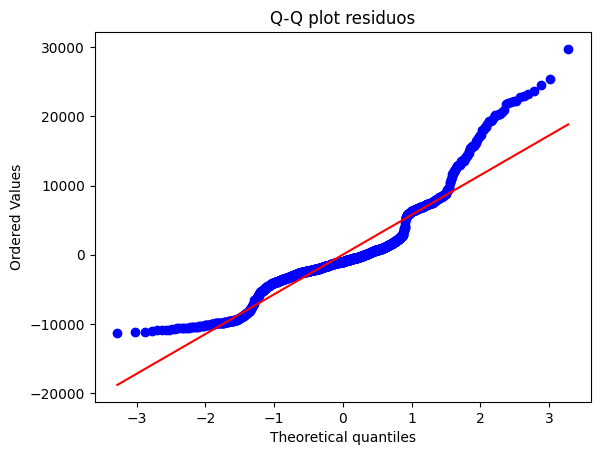

In [98]:
# AALISANDO A NORMALIDADE COM Q-Q PLOT
sts.probplot(residuos, dist = 'norm', plot = plt)
plt.title('Q-Q plot residuos')

### **Homocedasticidade**

- Teste Breusch-pagan
- Gráfico dos resíduos vs valores preditos

Os residuos tem um formato de cone vertical, não estão bem distribuidos.

O teste Breusch-pagan, acusa com o p-valor extremamente baixo: p_valor = 6.1066794722808924e-24

Conclusão: os resíduos apresentam heterocedasticidade, ou seja, o modelo não mantém a variância constante dos erros.

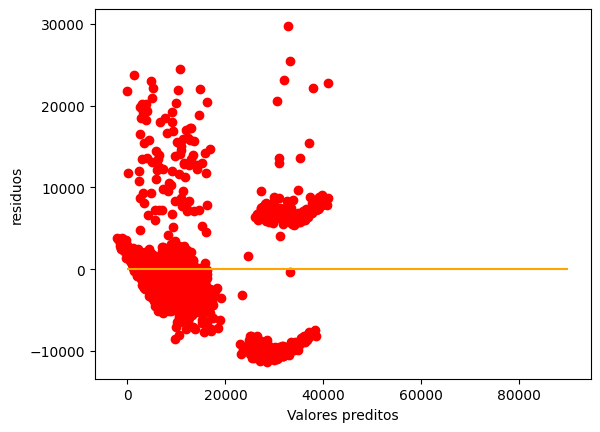

In [99]:
# ANALISANDO A HOMOCEDASTICIDADE POR GRÁFICO
plt.scatter(y = residuos, x = multipla_sts.predict(), color = 'red')
plt.hlines(y = 0, xmin =0, xmax= 90000, color = 'orange')
plt.ylabel('residuos')
plt.xlabel('Valores preditos')
plt.show()

In [100]:
# TESTE ESTATISTICO PARA VERIFICAR SE É OU NÃO HOMOGENEO
estatistica, p, f, fp = sms.het_breuschpagan(multipla_sts.resid, multipla_sts.model.exog)
print('P valor: {}'.format(p))

P valor: 6.1066794722808924e-24


### **Detecção de outliers**

- Estatística de outliers pelo metodo outliers_test()
- Avaliação dos limites ±3

Resultado esperado: presença de outliers, o que é normal neste dataset e não compromete o modelo simples

In [101]:
# ANALISANDO OS OUTLIERS DOS RESIDUOS
outliers = multipla_sts.outlier_test()
print(f'Outliers minimo: {outliers.min()}, outlier maximo: {outliers.max()}')

Outliers minimo: student_resid   -1.880403e+00
unadj_p          7.713955e-07
bonf(p)          1.032127e-03
dtype: float64, outlier maximo: student_resid    4.966191
unadj_p          0.999820
bonf(p)          1.000000
dtype: float64


### **Análise de Multicolinearidade (VIF)**

O VIF é utilizado para detectar multicolinearidade entre
as variáveis independentes. Valores altos indicam que a variável está correlacionada
com outras features, o que pode comprometer a estabilidade da regressão linear.

- VIF < 5 → sem colinearidade preocupante  
- 5 ≤ VIF < 10 → colinearidade moderada  
- VIF ≥ 10 → colinearidade forte  

Abaixo calculei o VIF para todas as features do modelo.

In [111]:
# SELECIONANDO AS VARIAVEIS FEATURES PÓS ENCODING
X_vif = dados_encoding[['age','sex','bmi','children','smoker','region']].astype(float)

# CRIA UM DATAFRAME PARA ARMAZENAR OS VIFs
vif = pd.DataFrame()
vif["Variavel"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# VIF <= 1: fraco, 
vif

,Variavel,VIF
0,age,7.551348
1,sex,2.001061
2,bmi,10.371829
3,children,1.801245
4,smoker,1.256837
5,region,2.924528


In [105]:
# VERIFICANDO A AUSENCIA DE MULTICOLINEARIDADE ENTRE AS FEATURES NA TABELA
#considerada multicolinearidade quando r > 0.9
variaveis = dados_encoding[['age','sex','bmi','children','smoker','region']]
correlacoes = variaveis.corr(method = 'pearson')
correlacoes

,age,sex,bmi,children,smoker,region
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000


### **Comparação entre Valores Reais e Valores Preditos**

Nesta etapa, foi avaliado o quão bem o modelo de Regressão Linear Múltipla conseguiu aproximar os valores reais do custo do seguro. Para isso:

- Foram gerados os valores previstos (multipla_sts.fittedvalues).

- Criei um gráfico de dispersão comparando valores reais (charges) com valores previstos.

- Uma linha de regressão foi adicionada para facilitar a visualização do ajuste.

Se o modelo fosse adequado, os pontos deveriam se alinhar próximos da linha diagonal — indicando previsões consistentes.
No entanto, observei grande dispersão, reforçando que o modelo linear não captura bem a variabilidade real dos dados.

In [109]:
# COMPRANDO AS PREVISÕES FEITAS PELO MODELO X VALORES REAIS
dados_encoding['Previsao'] = multipla_sts.fittedvalues
dados_encoding.head()


,age,sex,bmi,children,smoker,region,charges,Previsao
0,19,0,27.900,0,1,3,16884.92400,25111.241864
1,18,1,33.770,1,0,2,1725.55230,3687.605173
2,28,1,33.000,3,0,2,4449.46200,6963.145707
3,33,1,22.705,0,0,1,21984.47061,3741.308405
4,32,1,28.880,0,0,1,3866.85520,5537.640897


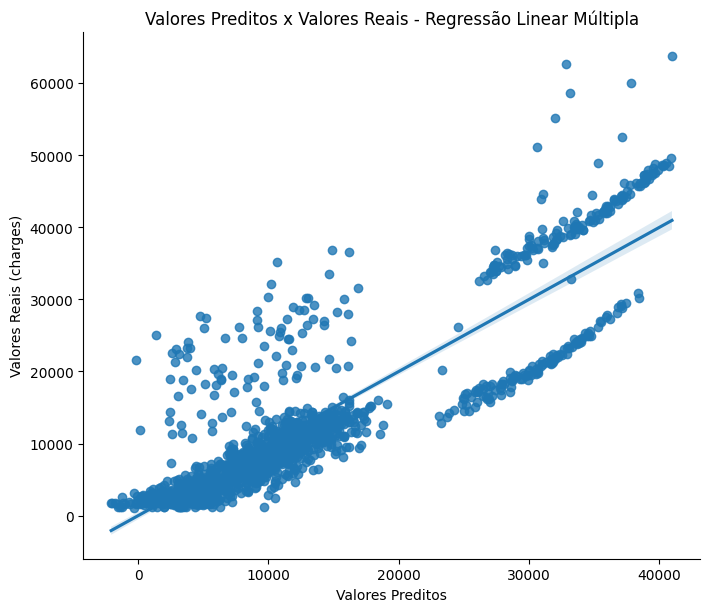

In [110]:
# AJUSTE DA RETA DOS VALORES PREVISTOS COM OS VALORES REAIS

# GRÁFICO PREVISTO X REAL
sns.lmplot(x='Previsao',y='charges',data=dados_encoding,height=6,aspect=1.2)

# CONFIGURAÇÕES DO GRÁFICO
plt.title('Valores Preditos x Valores Reais - Regressão Linear Múltipla')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais (charges)')
plt.show()


### **CONCLUSÃO FINAL DA REGRESSÃO LINEAR MULTIPLA**
aplicação da Regressão Linear Múltipla permitiu avaliar de forma conjunta o impacto de todas as variáveis sobre o custo do seguro de saúde. No entanto, apesar de oferecer um bom ponto de partida para análise estatística, o modelo não demonstrou capacidade adequada de representar a complexidade real do problema.

Os diagnósticos dos resíduos mostraram violações importantes dos pressupostos do modelo — falta de normalidade, heterocedasticidade e presença de outliers com forte influência. Além disso, a dispersão observada entre valores reais e previstos indica que o comportamento dos dados não segue uma relação linear simples. Embora a multicolinearidade não tenha sido severa, ela contribui para instabilizar os coeficientes sem resolver o problema estrutural do modelo.

Essa etapa cumpre seu papel exploratório e confirma a necessidade de avançar para modelos de Machine Learning, que conseguem capturar relações mais complexas entre as variáveis e melhorar significativamente a qualidade das previsões.

## **PRE-PROCESSAMENTO: CRIAÇÃO DOS PIPELINES E EVITANDO DATA LEAKAGE**

Nesta etapa, foi realizado o pré-processamento completo para preparar os dados antes da aplicação dos algortimos de Machine Learning. O objetivo principal é:

- Evitar data leakage
- Garantir que cada modelo receba os dados no formato adequado
- Aplicar os pre-processamentos para os algortimos de ML (Variáveis dummy, escalonamento, encoding)
- Escalonar o target
- Criação do kfold para futuras validações cruzada
- Facilitar avaliação e reprodutibilidade

### **Separação das Features e Target (ANTES de qualquer pré-processamento)**
Passo essencial para evitar vazamento de dados, isso assegura que o modelo aprenda somente com os dados de treino, evitando influências indevidas do conjunto de teste.

In [3]:
#sepanrado as features
features = dados.drop('charges', axis = 1)
features.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [4]:
#separando o alvo
tagert = dados['charges']
tagert.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [5]:
# separação de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(features, tagert, test_size = 0.3, random_state = 10)


In [33]:
# Kfold para futura validações cruzada
kfold = KFold(n_splits = 15, shuffle = True, random_state= 0)

### **Identificação dos tipos de variáveis**
As colunas foram divididas conforme seu tipo e necessidade específica de pré-processamento. Cada grupo receberá um tratamento diferente, garantindo compatibilidade com bibliotecas de ML.

In [6]:
#features separadas para serem pre processadas
numericas = ['age', 'bmi','children']
binarios = ['sex','smoker']
categoricas = ['region']

### **Pré-processamento específico para cada família de modelos**

Algoritmos diferentes exigem pré-processamentos diferentes, No entanto. Realizei alguns testes antes de finalizar o notebook e por mais que alguns algortimos como os pertencentes à familia de arvores não tenham a necessidade de normalização/padronização. Obtive resultados nas metricas de desempenho desses algortimos muito desanimadores e após testar o mesmo pre-processamento em todos os modelos, obtive resultados compravéis, e é por isso que decidi manter o mesmo pre-processamento para todos




In [23]:
# pipeline que será utilizado para a REGRESSÃO COM VETORES DE SUPORTE (SVR)
pre_processamento = ColumnTransformer(
    transformers=[
        ('binari', OrdinalEncoder(), binarios),
        ('categoric', OneHotEncoder(drop = 'first'), categoricas),
        ('numeric', StandardScaler(), numericas)
    ]
 )
#exibe o pre-processamento
pre_processamento


ColumnTransformer(transformers=[('binari', OrdinalEncoder(), ['sex', 'smoker']),
                                ('categoric', OneHotEncoder(drop='first'),
                                 ['region']),
                                ('numeric', StandardScaler(),
                                 ['age', 'bmi', 'children'])])

In [ ]:
# pipeline que será utilizado para DECISION TREE, RANDOM FOREST, XGBOOST, LIGHTGBM, CATBOOST
pre_processamento_Arvore = ColumnTransformer(
    transformers = [
        ('binari',OrdinalEncoder(), binarios),
        ('categoric', OneHotEncoder(drop = 'first'), categoricas),
        ('numeric', StandardScaler(), numericas)
    ]
)
#exibe o pre-processamento
pre_processamento_Arvore

### **Criação dos Pipelines para cada Modelo de Machine Learning**

A etapa seguinte foi construir pipelines completos, contendo:

- Pré-processamento
- Modelo
- Escalonamento do target via TransformedTargetRegressor

In [63]:
# SVR
pipeline_SVR = Pipeline(steps = [
    ('preprocess', pre_processamento),
    ('model', SVR(kernel = 'rbf'))
])
#escalonando o target
svr_escalonado = TransformedTargetRegressor(
    regressor = pipeline_SVR,
    transformer = StandardScaler()
)
# Decision Tree
pipeline_Decision = Pipeline(steps = [
    ('preprocess', pre_processamento),
    ('model', DecisionTreeRegressor())
])
# Escalonando o target para arvore de decisão
decision_escalonado = TransformedTargetRegressor(
    regressor = pipeline_Decision,
    transformer = StandardScaler()
)

# Random Forest
pipeline_Random = Pipeline(steps = [
    ('preprocess', pre_processamento),
    ('model', RandomForestRegressor())
])
# Escalonando o target para Random Forest
forest_escalonado = TransformedTargetRegressor(
    regressor = pipeline_Random,
    transformer = StandardScaler()
)

# XGBOOST
pipeline_XGB = Pipeline(steps = [
    ('preprocess', pre_processamento),
    ('model', XGBR())
])

# Escalonando o target para XGBOOST
XGB_escalonado = TransformedTargetRegressor(
    regressor = pipeline_XGB,
    transformer = StandardScaler()
)


# lightgbm
pipeline_LIGHT = Pipeline(steps = [
    ('preprocess', pre_processamento),
    ('model', LHTR())
])

# Escalonando o target para LIGHTGMB
LHT_escalonado = TransformedTargetRegressor(
    regressor = pipeline_LIGHT,
    transformer = StandardScaler()
)


# catboost
pipeline_CAT = Pipeline(steps = [
    ('preprocess', pre_processamento),
    ('model', CTBR())
])
# Escalonando o target para CATBOOST
CAT_escalonado = TransformedTargetRegressor(
    regressor = pipeline_CAT,
    transformer = StandardScaler()
)
pipeline_MLP = Pipeline(steps =[
    ('preprocess', pre_processamento),
    ('model',MLPRegressor())
])
MLP_escalonado = TransformedTargetRegressor(
    regressor = pipeline_MLP,
    transformer = StandardScaler()
)

### **Conclusão da Etapa de Pré-Processamento**

Nesta etapa foi realizado:

- Separação correta entre treino e teste (evitando data leakage)
- Preparação individual para cada tipo de modelo
- Criação de pipelines completos e profissionais
- Escalonamento adequado do target
- Base sólida para treinamento, ajuste de hiperparâmetros e avaliação

Com isso, os dados estão totalmente prontos para a etapa seguinte:

## **TREINAMENTO DOS MODELOS DE MACHINE LEARNING**

Nesta seção, após realizar toda a etapa do pré-processamento (separação de features/target, divisão treino-teste, criação dos pipelines e escalonamento do target), iniciaremos o treinamento dos algortimos de machine learning aplicados ao problema de previsão de custos de seguro de saúde (charges)

Os modelos utilizados serão:
- Support Vector Machine (SVR)
- Decision Tree Regressor
- Random Forest Regressor
- XGboost Regressor
- LightGBM Regressor
- Catboost Regressor
- Multi-layer Perceptron (MLP Regressor)

Cada modelo será treinado utilizando validação cruzada (KFold), com o objetivo de comprar desempenho e selecionar melhor modelo para previsão final.

## **Support Vector Machine (SVR)**

Nesta subseção será realizado o treinamento, avaliação e validação cruzada do modelo SVR.

O pipeline aplicado contém:

- Codificação ordinal para váriaveis binárias (sex, smoker)
- One-Hot Encoding para variáveis categóricas (region)
- Escalonamento (StandardScaler) para variáveis numéricas.
- Escalonamento do target via TransformedTargetRregressor

As métricas utilizada para avaliar o desempenho serão:

- R² (Treino e teste)
- MAE -- Erro Médio Absoluto
- MSE -- Erro Médio Quadrático
- RMSE -- Raiz do Erro Médio Quadrático
- Validação cruzada  KFold com 15 folds

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [25]:
#Treinando o modelo com os dados de treino.
svr_escalonado.fit(x_treino, y_treino)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model', SVR())]),
                           transformer=StandardScaler())

In [36]:
# COEFICIENTE DE DETERMINAÇÃO DO TREINO E TESTE
print('Coeficiente de Determinação(Treino): {:.2%}'.format(svr_escalonado.score(x_treino, y_treino)))
print('Coeficiente de Determinação(Teste): {:.2%}'.format(svr_escalonado.score(x_teste, y_teste)))


Coeficiente de Determinação(Treino): 85.97%
Coeficiente de Determinação(Teste): 82.42%


In [37]:
# PREVISÕES DO TESTE
previsoes = svr_escalonado.predict(x_teste)
previsoes

array([ 7687.10238902,  5819.01149175, 13727.43395314, 14190.31338792,
        4366.5747248 ,  8610.14126208, 10244.61043548, 18214.87222524,
        9371.08286212, 17347.80027853,  3470.78782511,  4517.29911592,
        7857.89981558,  9724.55441612, 10505.70822186, 14283.31164711,
        2140.67424032, 16097.9877613 , 12112.41354646, 25076.49719741,
       36068.59561099,  3340.27447172,  3413.64262307,  7718.77230574,
        4282.73646524, 13866.71454364,  8552.14468674, 12351.88103648,
        5138.0410476 , 27324.74762169,  2394.14164628, 40247.33693696,
        7842.18988674,  9019.47661127,  4287.37564645,  6887.87296429,
       14085.91187715, 10290.36661166, 10619.92929306,  8863.84586196,
       14945.26986941, 10317.86121132,  5775.92776936,  8661.83404789,
        3733.8692296 ,  7291.19939965,  9874.31577304, 33294.43739271,
       13287.11612217, 12610.22221079, 39797.5999076 ,  2944.33106068,
        8499.50552198, 14707.26071546, 10722.85276311, 13983.13049159,
      

### **Avaliando métricas de desempenho (SVR)**
Nesta seção são avaliadas as métricas de erro do modelo SVR aplicado ao conjunto de teste.  

As métricas utilizadas foram:

- MAE (Erro Médio Absoluto)  
- MSE (Erro Quadrático Médio)
- RMSE (Raiz do Erro Quadrático Médio)
- R² médio (Validação Cruzada)

Essas métricas permitem avaliar a precisão do modelo e sua capacidade de generalização.

In [38]:
#Erro médio absoluto
mean_absolute_error(y_teste, previsoes)

2585.2594249553495

In [39]:
#Erro medio quadratico
mean_squared_error(y_teste, previsoes)

22828353.326455396

In [40]:
#Raiz do erro médio quadratico
np.sqrt(mean_squared_error(y_teste, previsoes))

4777.902607468615

In [41]:
#determinando o fold e realizando a validação cruzada para o coeficiente de determinação médio
resultado = cross_val_score(svr_escalonado, features, tagert, cv = kfold, scoring= 'r2')
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 83.24%


### **Análise de erros do modelo (SVR)**

A análise de erros é fundamental para entender **como o modelo erra**, se há padrões nos resíduos ou sinais de problemas como heterocedasticidade, viés ou erros sistemáticos.

Nesta seção são avaliados:

- Distribuição dos resíduos
- Resíduos vs Previsões
- Valores reais vs Valores previstos
- Estatistica básica dos erros

Essa análise permite avaliar a estabilidade e a qualidade das previsões do modelo.

### **Cálculo dos resíduos**


In [44]:
# CÁLCULO DOS RESÍDUOS
residuos = y_teste - previsoes
# EXIBINDO OS PRIMEIROS RESÍDUOS
residuos.head()

7        -405.596789
999      -551.193342
1209    -1380.261953
491     10322.777872
625      -630.110025
Name: charges, dtype: float64

### **Distribuição dos resíduos**

Objetivo é identificar:
- Verificar simetria
- Caudas longas 
- Se o modelo erra mais pra cima ou pra baixo.

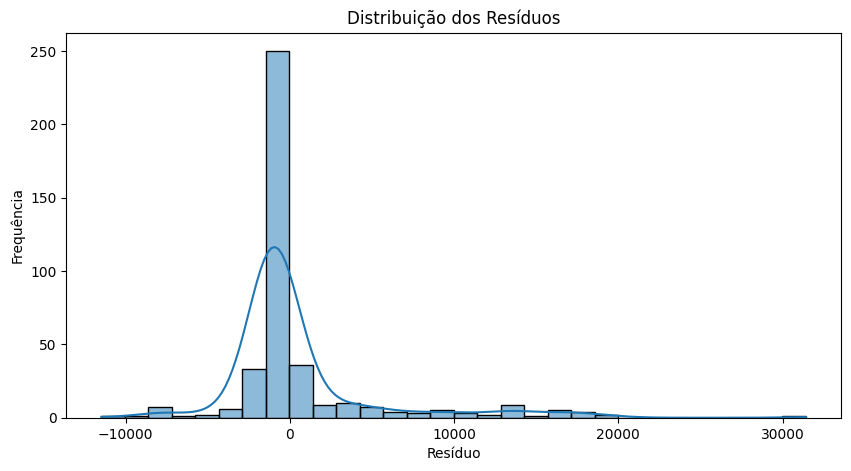

In [52]:
# DISTRIBUIÇÃO DOS RESÍDUOS
plt.figure(figsize=(10,5)) # TAMANHO DA FIGURA
sns.histplot(residuos, kde=True, bins=30) # SELEÇÃO DOS RESÍDUOS, ATIVA A LINHA E NUMERO DE BINS
plt.title("Distribuição dos Resíduos") # TITULO DO GRÁFICO
plt.xlabel("Resíduo") # XLABEL
plt.ylabel("Frequência") # Y LABEL
plt.show() # EXIBE

### **Resíduos vs Previsões**
Objetivo é identificar:
- Heterocedasticidade
- Padrões (curvas -> Modelo linear inadequado)
- clusters de erro

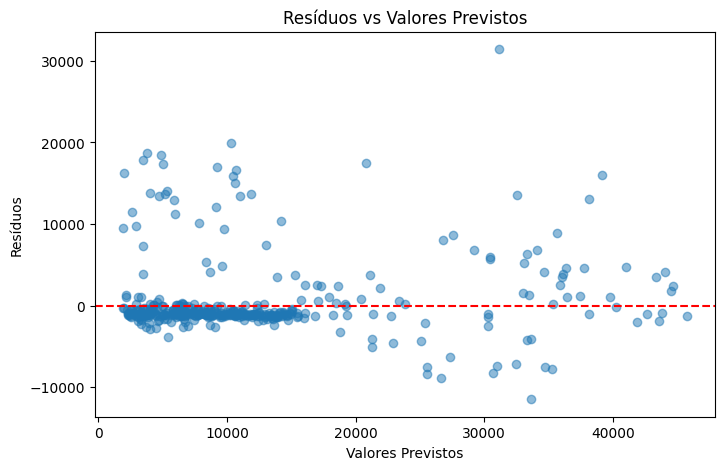

In [49]:
# GRÁFICO DE DISPERSSÃO, ANALISANDO OS RESÍDUOS VS PREVISÕES
plt.figure(figsize=(8,5)) # TAMANHO DA FIGURA
plt.scatter(previsoes, residuos, alpha=0.5) # DADOS
plt.axhline(0, color='red', linestyle='--') # FORMATAÇÃO DA COR E ESTILO DA RETA
plt.xlabel("Valores Previstos") # TITULO DO XLABEL
plt.ylabel("Resíduos") # TITULO DO YLABEL
plt.title("Resíduos vs Valores Previstos") # TITULO DO GRÁFICO
plt.show() # EXIBE O GRÁFICO


### **Real vs Previsto**

- Quanto mais proximo da linha vermelha, melhor o modelo.

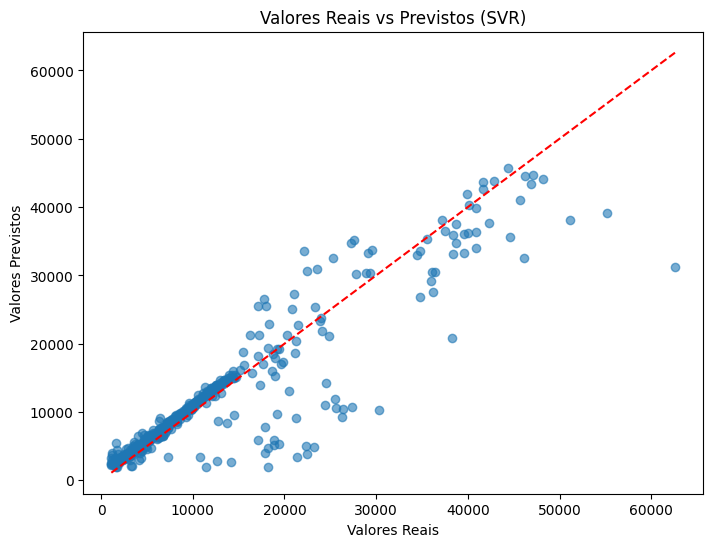

In [50]:
# GRÁFICO PARA VALORES REAIS X PREVISTO
plt.figure(figsize=(8,6)) # TAMANHO DA FIGURA
plt.scatter(y_teste, previsoes, alpha=0.6) # DADOS PLOTADOS
plt.plot([y_teste.min(), y_teste.max()],[y_teste.min(), y_teste.max()],color='red', linestyle='--') # CONFIGURAÇÕES DO GRÁFICO
plt.xlabel("Valores Reais") # XLABEL
plt.ylabel("Valores Previstos") # YLABEL
plt.title("Valores Reais vs Previstos (SVR)") # TITULO DO GRÁFICO
plt.show() # EXIBE


### **Resumo Estatístico dos resíduos**

- Quantidade
- Média
- Desvio padrão
- Minimo
- Quartis
- Maximo


In [51]:
# RESUMO DOS RESIDUOS
print("Resumo estatístico dos resíduos:")
print(pd.Series(residuos).describe())


Resumo estatístico dos resíduos:
count      402.000000
mean       500.227899
std       4757.565546
min     -11471.916118
25%      -1203.842088
50%       -966.504694
75%         -6.801300
max      31421.020666
Name: charges, dtype: float64


### **Interpretação dos resultados - SVR** 

O modelo SVR apresentou um desempenho razoável, mas mostrou dificuldades para capturar variações maiores do valor-alvo, como visto no gráfico Real vs Previsto, onde os pontos se afastam da diagonal nos valores mais altos.

Os resíduos se concentram próximo de zero, mas com leve assimetria à direita, indicando tendência a **subestimar valores elevados**.

O gráfico de Resíduos vs Previstos mostra um agrupamento muito denso nos valores iniciais, sugerindo que o modelo não conseguiu capturar totalmente a relação não linear entre as variáveis.
As métricas (MAE, RMSE) confirmam essa limitação, com erros relativamente altos em comparação a modelos pósterior.

### **Conclusão - Support Vecto Machine (SVR)**

O modelo SVR apresentou desempenho moderado, obtendo um R² inferior ao esperado tanto no treino quanto no teste. A análise dos resíduos mostrou resíduos mais espalhos em valores altos e um cluster denso nos valores iniciais e tendência de subestimação das previsões para valores mais altos, indicando dificuldade em capturar relações não lineares mais complexas no conjunto de dados.
Além disso, a validação cruzada revelou um R² médio bom se comparando ao coeficiente de determinação dos conjuntos de treino e teste.
Apesar de apresentar certa capacidade preditiva, o modelo não se destacou em relação às outras abordagens testadas e pode não ser a melhor escolha para produção.

## **DECISION TREE**
Nesta subseção será realizado o treinamento, otimização de hiperparametros, avaliação e validação cruzada do modelo Decision Tree.

O pipeline aplicado contém:
- Codificação ordinal para váriaveis binárias (sex, smoker)
- One-Hot Encoding para variáveis categóricas (region)
- Escalonamento (StandardScaler) para variáveis numéricas.
- Escalonamento do target via TransformedTargetRregressor

As métricas utilizada para avaliar o desempenho serão:
- R² (Treino e teste)
- MAE -- Erro Médio Absoluto
- MSE -- Erro Médio Quadrático
- RMSE -- Raiz do Erro Médio Quadrático
- Validação cruzada  KFold com 15 folds

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [54]:
# MODELO COM AS FEATURE E O TARGET PRE-PROCESSADO
decision_escalonado

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      DecisionTreeRegressor())]),
                           transformer=StandardScaler())

### **Otimização de hiperparâmetros - Decision Tree Regressor**

Nesta etapa, foi realizada a busca pelos melhores hiperparâmetros para o modelo Decision Tree Regressor, Utilizando a técnica de RandomizedSearch com validação cruzada (RandomizedSearchCV).

Objetivo dessa otimitzação é:
- Ajustar a profundidade da arvore (max_depth)
- Avaliar diferentes funções de impureza (criterion)
- Escolher o melhor mínimo de amostras para dividir um nó interno (min_samples_split)
- Melhor mínimo de amostras necessaria para estar em um nó folha (min_samples_leaf)
- E selecionar a combinação que produza o melhor desempenho com base no coeficiente de determinação (R²)

O procedimento consiste em:
- Definir uma distribuição com faixa de valores inteiros e strings para um seleção aleatória
- Avaliar a melhor combinação com base no coeficiente de determinação.
- Criar um pipeline final com os melhores hiperparâmetros encontrados.

In [64]:
parametros_random_tree = RandomizedSearchCV(estimator = decision_escalonado, param_distributions = {'regressor__model__criterion':['squared_error','friedman_mse','absolute_error'], 'regressor__model__max_depth': sts.randint(1,10),
                                                                                                    'regressor__model__min_samples_leaf':sts.randint(2,8), 'regressor__model__min_samples_split': sts.randint(2,8)},
                                                                                                    scoring = 'r2', cv = 4, random_state = 0)
#passa os dados de treino para o modelo avaliar os melhores
parametros_random_tree.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(parametros_random_tree.best_params_))
print('Melhor score: {:.2%}'.format(parametros_random_tree.best_score_))
#define os melhores hiperparametros do modelo e atribui a variavel
melhor_tree = parametros_random_tree.best_estimator_

Melhor hiperparametro: {'regressor__model__criterion': 'absolute_error', 'regressor__model__max_depth': 4, 'regressor__model__min_samples_leaf': 2, 'regressor__model__min_samples_split': 3}
Melhor score: 84.96%


In [92]:
#Coeficiente de determinação do treino e do teste
print('Coeficiente de Determinação - Treino: {:.2%}'.format(melhor_tree.score(x_treino, y_treino)))
print('Coeficiente de Determinação - Teste: {:.2%}'.format(melhor_tree.score(x_teste, y_teste)))

Coeficiente de Determinação - Treino: 85.46%
Coeficiente de Determinação - Teste: 84.21%


In [77]:
#realizando as previsões do teste para comparar no olho com o target real
previsoes_tree = melhor_pipeline.predict(x_teste)
previsoes_tree

array([ 7151.092   ,  5978.28105 , 13837.9562  , 13837.9562  ,
        3862.307225,  5978.28105 ,  8857.20925 , 17560.37975 ,
        8857.20925 , 22218.1149  ,  3693.428   ,  2643.2685  ,
        8023.13545 ,  7151.092   ,  9120.45015 , 13837.9562  ,
        2643.2685  , 13837.9562  , 11841.608525, 19629.46885 ,
       41097.16175 ,  1842.519   ,  1842.519   ,  5978.28105 ,
        4892.3764  , 13837.9562  ,  8857.20925 , 11841.608525,
        3693.428   , 19629.46885 ,  1842.519   , 39919.925625,
        8023.13545 ,  8857.20925 ,  4892.3764  ,  7151.092   ,
       13837.9562  , 11113.4391  ,  9120.45015 ,  8857.20925 ,
       13837.9562  , 10631.56705 ,  5978.28105 ,  8023.13545 ,
        1842.519   ,  5978.28105 ,  8023.13545 , 37486.014   ,
       13837.9562  , 11841.608525, 37165.1638  ,  3862.307225,
        8023.13545 , 11841.608525, 11113.4391  , 13837.9562  ,
       11841.608525,  5978.28105 ,  5978.28105 , 41097.16175 ,
        1842.519   , 22218.1149  , 28868.6639  ,  2643.

In [72]:
#para ser comparado com as previsoes (target real)
y_teste

7        7281.50560
999      5267.81815
1209    12347.17200
491     24513.09126
625      3736.46470
           ...     
854     24106.91255
554     17878.90068
1278    22462.04375
374      1391.52870
6        8240.58960
Name: charges, Length: 402, dtype: float64

### **Avaliando métricas de desempenho (Decision Tree)**
Nesta seção são avaliadas as métricas de erro do modelo Decision Tree aplicado ao conjunto de teste.  

As métricas utilizadas foram:

- MAE (Erro Médio Absoluto)  
- MSE (Erro Quadrático Médio)
- RMSE (Raiz do Erro Quadrático Médio)
- R² médio (Validação Cruzada)

Essas métricas permitem avaliar a precisão do modelo e sua capacidade de generalização.

In [83]:
# METRICAS DE DESEMPENHO DO MODELO.
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_tree)))
print('Erro Quadrático Médio: {}'.format(mean_squared_error(y_teste, previsoes_tree)))
print('Raiz quadrada do erro médio(RMSE): {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_tree))))
print('Coeficiente de determinação (R2): {} '.format(r2_score(y_teste, previsoes_tree)))


Erro médio absoluto: 2010.443750146766
Erro Quadrático Médio: 20607075.912015587
Raiz quadrada do erro médio(RMSE): 4539.501725081243
Coeficiente de determinação (R2): 0.8413105496161755 


In [79]:
# VALIDAÇÃO CRUZADA
resultado = cross_val_score(melhor_tree, features, tagert, cv = kfold, scoring= 'r2')
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 84.18%


### **Análise de erros do modelo (Decision Tree)**

A análise de erros é fundamental para entender **como o modelo erra**, se há padrões nos resíduos ou sinais de problemas como heterocedasticidade, viés ou erros sistemáticos.

Nesta seção são avaliados:

- Distribuição dos resíduos
- Resíduos vs Previsões
- Valores reais vs Valores previstos
- Estatistica básica dos erros

Essa análise permite avaliar a estabilidade e a qualidade das previsões do modelo.

### **CÁLCULO DOS RESÍDUOS**

In [80]:
# CÁLCULO DOS RESÍDUOS
residuos_tree = y_teste - previsoes_tree
# EXIBINDO OS PRIMEIROS RESÍDUOS
residuos_tree.head()

7         130.413600
999      -710.462900
1209    -1490.784200
491     10675.135060
625      -125.842525
Name: charges, dtype: float64

### **Distribuição dos resíduos**

Objetivo é identificar:
- Verificar simetria
- Caudas longas 
- Se o modelo erra mais pra cima ou pra baixo.

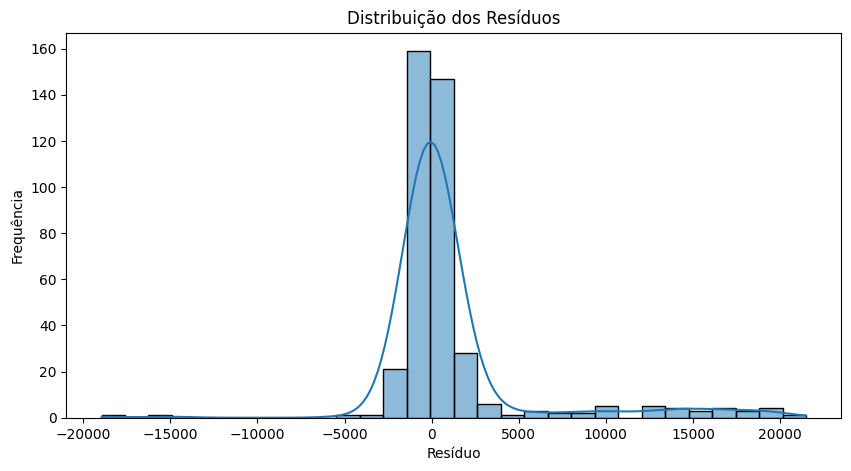

In [84]:
# DISTRIBUIÇÃO DOS RESÍDUOS
plt.figure(figsize=(10,5)) # TAMANHO DA FIGURA
sns.histplot(residuos_tree, kde=True, bins=30) # SELEÇÃO DOS RESÍDUOS, ATIVA A LINHA E NUMERO DE BINS
plt.title("Distribuição dos Resíduos") # TITULO DO GRÁFICO
plt.xlabel("Resíduo") # XLABEL
plt.ylabel("Frequência") # Y LABEL
plt.show() # EXIBE

### **Resíduos vs Previsões**
Objetivo é identificar:
- Heterocedasticidade
- Padrões (curvas -> Modelo linear inadequado)
- clusters de erro

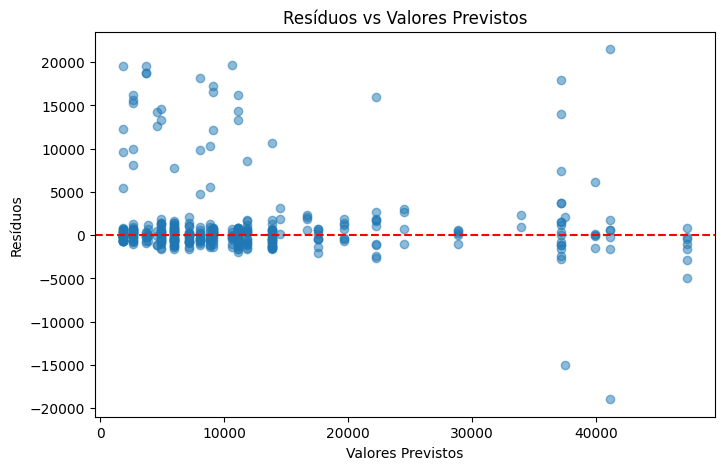

In [87]:
# GRÁFICO DE DISPERSSÃO, ANALISANDO OS RESÍDUOS VS PREVISÕES
plt.figure(figsize=(8,5)) # TAMANHO DA FIGURA
plt.scatter(previsoes_tree, residuos_tree, alpha=0.5) # DADOS
plt.axhline(0, color='red', linestyle='--') # FORMATAÇÃO DA COR E ESTILO DA RETA
plt.xlabel("Valores Previstos") # TITULO DO XLABEL
plt.ylabel("Resíduos") # TITULO DO YLABEL
plt.title("Resíduos vs Valores Previstos") # TITULO DO GRÁFICO
plt.show() # EXIBE O GRÁFICO


### **Real vs Previsto**
- Quanto mais proximo da linha vermelha, melhor o modelo.

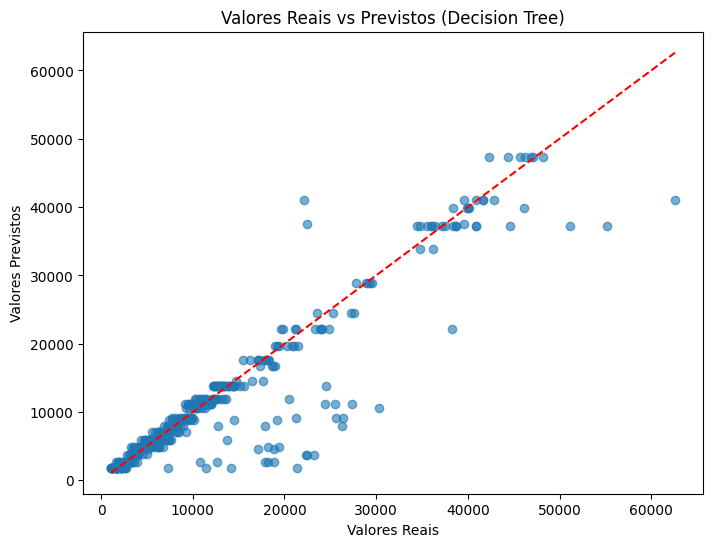

In [89]:
# GRÁFICO PARA VALORES REAIS X PREVISTO
plt.figure(figsize=(8,6)) # TAMANHO DA FIGURA
plt.scatter(y_teste, previsoes_tree, alpha=0.6) # DADOS PLOTADOS
plt.plot([y_teste.min(), y_teste.max()],[y_teste.min(), y_teste.max()],color='red', linestyle='--') # CONFIGURAÇÕES DO GRÁFICO
plt.xlabel("Valores Reais") # XLABEL
plt.ylabel("Valores Previstos") # YLABEL
plt.title("Valores Reais vs Previstos (Decision Tree)") # TITULO DO GRÁFICO
plt.show() # EXIBE


### **Resumo Estatístico dos resíduos**

- Quantidade
- Média
- Desvio padrão
- Minimo
- Quartis
- Maximo

In [91]:
# RESUMO DOS RESIDUOS
print("Resumo estatístico dos resíduos:")
print(pd.Series(residuos).describe())


Resumo estatístico dos resíduos:
count      402.000000
mean       500.227899
std       4757.565546
min     -11471.916118
25%      -1203.842088
50%       -966.504694
75%         -6.801300
max      31421.020666
Name: charges, dtype: float64


### **Interpretação dos resultados - Decision Tree** 

O modelo Decision Tree apresentou desempenho moderado, conseguindo capturar parte das relações entre as variáveis, mas com sinais claros de superajuste. No gráfico Real vs Previsto, observa-se que muitos pontos se alinham próximos da diagonal nos valores iniciais, porém há grande dispersão nos valores mais altos e mais baixos, indicando instabilidade nas previsões.

Os resíduos mostram uma distribuição irregular, com faixas concentradas que evidenciam cortes rígidos típicos de árvores de decisão. Essa característica indica que o modelo tende a fazer previsões com poucos valores distintos, resultando em saltos abruptos.

No gráfico de Resíduos vs Previstos, nota-se um padrão claro de blocos, o que reforça a limitação da árvore em capturar transições suaves nos dados. Isso também indica falta de generalização.

As métricas (MAE, RMSE) refletem essa instabilidade: embora o erro médio seja aceitável em algumas faixas, o erro quadrático se destaca devido a previsões distantes da realidade em casos mais extremos.

### **Conclusão – Decision Tree**

O Decision Tree mostrou-se um modelo capaz de aprender padrões básicos dos dados, mas apresentou limitações importantes de generalização, resultando em previsões instáveis e dependentes demais do conjunto de treino. A presença de blocos rígidos nas previsões e a alta dispersão em valores extremos indicam que a árvore não conseguiu capturar adequadamente a complexidade das relações entre as variáveis. Apesar de um desempenho aceitável em faixas intermediárias, o aumento do erro em casos extremos e os sinais de superajuste tornam o modelo menos confiável quando comparado a alternativas mais robustas. Assim, o Decision Tree não se destaca como uma das melhores escolhas para este problema.

## **RANDOM FOREST**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
# modelo com as features e targer pre-processados
forest_escalonado

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      RandomForestRegressor())]),
                           transformer=StandardScaler())

In [ ]:
parametros_grid = dict(regressor__model__max_depth = [5,7,2,10,8], regressor__model__random_state = [5,15,20,48,3], regressor__model__n_estimators = [60,100,150,180,200])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__max_depth']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__n_estimators']))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_random = GridSearchCV(forest_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_random.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_random.best_params_))
print('Melhor score: {}'.format(grid_random.best_score_))
#criando o modelo ja com os melhores hyperparametros
melhor_pipeline_RF = grid_random.best_estimator_

Numero de combinações de hiperparametros: 125
Melhor hiperparametro: {'regressor__model__max_depth': 5, 'regressor__model__n_estimators': 100, 'regressor__model__random_state': 3}
Melhor score: 0.8574892260073853


In [ ]:
#coeficiente de determinação do treino e teste
print('Coeficiente de determinação(treino): {:.2%}'.format(melhor_pipeline_RF.score(x_treino, y_treino)))
print('Coeficiente de determinação(teste): {:.2%}'.format(melhor_pipeline_RF.score(x_teste, y_teste)))

Coeficiente de determinação(treino): 89.44%
Coeficiente de determinação(teste): 85.83%


In [ ]:
#previsoes feitas
previsoes_rf = melhor_pipeline_RF.predict(x_teste)
previsoes_rf

array([ 7344.62272124,  6238.17384297, 17303.22956665, 14538.92603136,
        4618.2790399 ,  7291.51837667,  9567.88391548, 18818.67386055,
        9544.32508562, 21779.52529103,  6989.35834518,  4078.31402665,
        7743.47956953,  7654.97923105,  9979.025033  , 14331.27717042,
        4786.92639538, 18810.56407941, 12338.16314905, 19683.24952099,
       41876.21729217,  2688.86853531,  2517.26981517,  6942.33623784,
        5936.24470856, 13905.0471097 ,  9863.50912507, 14464.53480122,
        5503.18383779, 20671.12852511,  2578.30195321, 39698.30765631,
        8978.96128604,  9629.0720405 ,  6330.09731247,  7907.44250698,
       14002.51282878, 12392.46019238, 11329.86466512, 10532.34312366,
       14217.04873583, 11133.90244744,  6238.17384297,  8701.23429313,
        2775.44589196,  7178.74867864,  9416.52773794, 40273.79145716,
       14140.17276122, 12607.38768592, 40660.51697212,  4651.40488175,
        9243.2336695 , 14651.1514767 , 12352.92591009, 14083.60798198,
      

**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#erro medio absoluto e raiz do erro quadratico medio
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_rf)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_rf))))


Erro médio absoluto: 2415.7053150921906
Raiz do erro quatrático médio: 4289.224855746106


**VALIDAÇÃO CRUZADA**

In [ ]:
#validação cruzada do modelo
resultado = cross_val_score(melhor_pipeline_RF, features, tagert, cv = kfold, scoring= 'r2')
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 85.35%


#**XGBOOST**

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [ ]:
# modelo com as features e targer pre-processados
XGB_escalonado

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsamp...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...))]),
                           transformer=StandardScaler())

In [ ]:
parametros_grid = dict(regressor__model__max_depth = [5,7,2,10,8], regressor__model__random_state = [5,15,3], regressor__model__n_estimators = [60,100,150,180,], regressor__model__learning_rate = [0.01,0.05,0.08,0.03,0.1])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__max_depth']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__n_estimators'] * len(parametros_grid['regressor__model__learning_rate'])))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_XG = GridSearchCV(XGB_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_XG.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_XG.best_params_))
print('Melhor score: {:.2%}'.format(grid_XG.best_score_))
melhor_pipeline_XG = grid_XG.best_estimator_

Numero de combinações de hiperparametros: 300
Melhor hiperparametro: {'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 60, 'regressor__model__random_state': 5}
Melhor score: 85.89%


In [ ]:
#Coeficiente de determinação do treino e teste
print('Coeficiente de Determinação: {:.2%}'.format(melhor_pipeline_XG.score(x_treino, y_treino)))
print('Coeficiente de Determinação: {:.2%}'.format(melhor_pipeline_XG.score(x_teste, y_teste)))

Coeficiente de Determinação: 87.56%
Coeficiente de Determinação: 85.80%


In [ ]:
#previsoes do modelo
previsoes_XG = melhor_pipeline_XG.predict(x_teste)
previsoes_XG

array([ 8021.0923,  6413.321 , 16739.334 , 14269.751 ,  4575.334 ,
        7971.922 , 10277.831 , 18959.53  ,  9904.829 , 22763.928 ,
        4886.323 ,  4268.621 ,  8615.432 ,  8541.837 , 10389.721 ,
       14269.751 ,  5233.415 , 17065.8   , 12351.797 , 21588.008 ,
       40538.09  ,  3251.2122,  2885.551 ,  7451.1772,  6110.042 ,
       14525.127 , 10266.848 , 13723.298 ,  5672.422 , 21998.156 ,
        2020.2716, 39226.34  ,  9123.08  ,  9292.663 ,  6154.1807,
        8226.346 , 14381.589 , 12663.187 ,  9804.167 , 10098.995 ,
       14692.9795, 10997.588 ,  6413.321 ,  9290.933 ,  3484.176 ,
        7758.6855,  8722.749 , 38092.168 , 14269.751 , 12370.866 ,
       39003.523 ,  4788.5703,  9529.08  , 14360.063 , 12626.242 ,
       14525.127 , 13149.223 ,  7320.2695,  7841.0137, 41560.883 ,
        2885.551 , 24290.951 , 26779.695 ,  3351.6155, 19728.455 ,
        8992.172 ,  6323.2783,  8541.837 ,  9529.08  ,  9204.006 ,
        8503.594 ,  4216.006 ,  7971.922 ,  8541.837 ,  9659.9

In [ ]:
#target real para comprar com as previsoes
y_teste

,charges
7,7281.50560
999,5267.81815
1209,12347.17200
491,24513.09126
625,3736.46470
...,...
854,24106.91255
554,17878.90068
1278,22462.04375
374,1391.52870


**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#metricas de desempenho
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_XG)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_XG))))


Erro médio absoluto: 2494.2957962978467
Raiz do erro quatrático médio: 4294.461524597512


**VALIDAÇÃO CRUZADA**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline_XG, features, tagert, cv = kfold, scoring= 'r2')
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 85.64%


#**LIGHTGBM**

https://colab.research.google.com/drive/1PThpTTfytAd-54-2KYaV91rLz9dgaTy_#scrollTo=d97GRWSiiEva

In [ ]:
#modelo com as features e target pre-processados
LHT_escalonado

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      LGBMRegressor())]),
                           transformer=StandardScaler())

In [ ]:
parametros_grid = dict(regressor__model__max_depth = [5,7,2,8], regressor__model__random_state = [5,15,3], regressor__model__n_estimators = [60,150,180], regressor__model__learning_rate = [0.01,0.05,0.03], regressor__model__num_leaves = [50,120,80,150], regressor__model__verbose = [-1])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__max_depth']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__n_estimators'] * len(parametros_grid['regressor__model__learning_rate']
                                                                                                                                                                                                      * len(parametros_grid['regressor__model__num_leaves'] * len(parametros_grid['regressor__model__verbose'])))))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_LHT = GridSearchCV(LHT_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_LHT.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_LHT.best_params_))
print('Melhor score: {:.2%}'.format(grid_LHT.best_score_))
#criando o modelos com os melhores parametros
melhor_pipeline_LHT = grid_LHT.best_estimator_


Numero de combinações de hiperparametros: 432
Melhor hiperparametro: {'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 150, 'regressor__model__num_leaves': 50, 'regressor__model__random_state': 5, 'regressor__model__verbose': -1}
Melhor score: 85.93%


In [ ]:
#coeficiente de determinação médio
print('Coeficiente de Determinação(Treino): {:.2%}'.format(melhor_pipeline_LHT.score(x_treino, y_treino)))
print('Coeficiente de Determinação(Teste): {:.2%}'.format(melhor_pipeline_LHT.score(x_teste, y_teste)))

Coeficiente de Determinação(Treino): 87.56%
Coeficiente de Determinação(Teste): 85.57%


In [ ]:
#previsoes
previsoes_LHT = grid_LHT.predict(x_teste)
previsoes_LHT

array([ 7977.86046692,  6311.83821127, 17514.07892596, 14206.20598055,
        4494.18356849,  8089.30483701, 10758.18074126, 19214.05430618,
        9851.48046655, 22753.82422617,  4628.3456626 ,  4253.34072959,
        8422.64461598,  8655.74584987, 10519.25410122, 14206.20598055,
        5302.52481044, 17309.61163514, 12181.48878788, 21612.8607122 ,
       40590.29334039,  3381.61457527,  2249.60391726,  7411.41945407,
        5990.19918541, 14655.55168645, 10280.37353977, 13544.85738533,
        5646.66666342, 21739.44630894,  1491.94823953, 39078.56530607,
        8974.23066803,  9157.76792832,  6143.36498912,  8513.42093999,
       14127.14765608, 12884.82580395,  9833.21882252,  9733.84634845,
       15061.23551774, 10858.70093848,  6326.85424185,  9442.58487137,
        3525.68946166,  7646.73238432,  8521.58889938, 38387.78852879,
       14142.16368667, 12421.17308319, 39231.78835909,  4691.95728286,
        9287.01481239, 14428.35805117, 12657.40347167, 14591.50939257,
      

In [ ]:
#target atual
y_teste

,charges
7,7281.50560
999,5267.81815
1209,12347.17200
491,24513.09126
625,3736.46470
...,...
854,24106.91255
554,17878.90068
1278,22462.04375
374,1391.52870


**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#metricas de desempenho do modelo
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_LHT)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_LHT))))

Erro médio absoluto: 2481.0226050759134
Raiz do erro quatrático médio: 4328.850075557876


**VALIDAÇÃO CRUZADA**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline_LHT, features, tagert, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 85.43%


#**CATBOOST**

https://catboost.ai/docs/en/concepts/python-reference_catboostregressor

In [ ]:
parametros_grid = dict(regressor__model__depth = [5,7,2,8], regressor__model__random_state = [5,15,3], regressor__model__iterations = [100,150,220,280], regressor__model__learning_rate = [0.01,0.05,0.03])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__depth']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__iterations'] * len(parametros_grid['regressor__model__learning_rate'])))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_CAT = GridSearchCV(CAT_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_CAT.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_CAT.best_params_))
print('Melhor score: {:.2%}'.format(grid_CAT.best_score_))
melhor_pipeline_CAT = grid_CAT.best_estimator_

A saída de streaming foi truncada nas últimas 5000 linhas.
192:	learn: 0.2526144	total: 356ms	remaining: 160ms
193:	learn: 0.2520541	total: 358ms	remaining: 159ms
194:	learn: 0.2517444	total: 359ms	remaining: 157ms
195:	learn: 0.2513616	total: 361ms	remaining: 155ms
196:	learn: 0.2509570	total: 363ms	remaining: 153ms
197:	learn: 0.2505377	total: 365ms	remaining: 151ms
198:	learn: 0.2503976	total: 367ms	remaining: 149ms
199:	learn: 0.2501193	total: 368ms	remaining: 147ms
200:	learn: 0.2498150	total: 370ms	remaining: 145ms
201:	learn: 0.2496566	total: 372ms	remaining: 144ms
202:	learn: 0.2494803	total: 374ms	remaining: 142ms
203:	learn: 0.2492627	total: 375ms	remaining: 140ms
204:	learn: 0.2491037	total: 377ms	remaining: 138ms
205:	learn: 0.2484659	total: 379ms	remaining: 136ms
206:	learn: 0.2482801	total: 381ms	remaining: 134ms
207:	learn: 0.2477737	total: 382ms	remaining: 132ms
208:	learn: 0.2476879	total: 384ms	remaining: 130ms
209:	learn: 0.2474328	total: 386ms	remaining: 129ms
210:	

In [ ]:
#melhores parametros e melhor score
print('Melhor hiperparametro: {}'.format(grid_CAT.best_params_))
print('Melhor score: {:.2%}'.format(grid_CAT.best_score_))


Melhor hiperparametro: {'regressor__model__depth': 5, 'regressor__model__iterations': 150, 'regressor__model__learning_rate': 0.05, 'regressor__model__random_state': 15}
Melhor score: 86.05%


In [ ]:
#coeficiente de determinação médio
print('Coeficiente de Determinação(Treino): {:.2%}'.format(melhor_pipeline_CAT.score(x_treino, y_treino)))
print('Coeficiente de Determinação(Teste): {:.2%}'.format(melhor_pipeline_CAT.score(x_teste, y_teste)))

Coeficiente de Determinação(Treino): 88.89%
Coeficiente de Determinação(Teste): 85.49%


In [ ]:
#previsoes
previsoes_CAT = melhor_pipeline_CAT.predict(x_teste)
previsoes_CAT

array([ 7713.21308112,  5833.24598215, 16592.70160789, 14954.35681677,
        4167.29907111,  8383.57960676, 10363.60263776, 18122.57171397,
       10113.65443323, 21143.76819468,  5664.83720228,  3982.47220935,
        8345.82024997,  9257.59543738, 10551.50217054, 14585.49677612,
        4716.9708267 , 17621.26598243, 12858.63037058, 21483.14507676,
       40429.33625762,  3339.19852482,  2488.84866239,  7038.46303406,
        5895.33072547, 14164.52668267,  9773.87831143, 12908.47546177,
        5775.10889016, 22388.43423428,  1883.55009666, 39834.77176606,
        8730.14479768,  9285.39118988,  5818.43593669,  7770.31497427,
       14183.75210777, 10631.19127695, 10441.66729286,  9716.96309396,
       14838.85146579, 10885.5306441 ,  5855.29519347,  8949.84841576,
        2760.716914  ,  8780.52491753,  8834.88306538, 37776.79865418,
       13821.81828389, 12726.82560966, 41009.00126927,  3861.86520151,
        9109.0751206 , 16511.10552398, 11236.38250278, 14195.99586754,
      

**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#metricas de desempenho do modelo
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_CAT)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_CAT))))

Erro médio absoluto: 2450.496434715817
Raiz do erro quatrático médio: 4341.305349161423


**VALIDAÇÃO CRUZADA**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline_CAT, features, tagert, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

0:	learn: 0.9641592	total: 756us	remaining: 113ms
1:	learn: 0.9285215	total: 1.36ms	remaining: 100ms
2:	learn: 0.8954525	total: 1.95ms	remaining: 95.7ms
3:	learn: 0.8633889	total: 2.49ms	remaining: 90.8ms
4:	learn: 0.8337069	total: 3.36ms	remaining: 97.6ms
5:	learn: 0.8068932	total: 3.99ms	remaining: 95.7ms
6:	learn: 0.7794558	total: 5.11ms	remaining: 104ms
7:	learn: 0.7531400	total: 5.74ms	remaining: 102ms
8:	learn: 0.7279788	total: 6.72ms	remaining: 105ms
9:	learn: 0.7063716	total: 7.04ms	remaining: 98.6ms
10:	learn: 0.6854055	total: 7.62ms	remaining: 96.3ms
11:	learn: 0.6642801	total: 8.17ms	remaining: 94ms
12:	learn: 0.6441039	total: 8.7ms	remaining: 91.7ms
13:	learn: 0.6257366	total: 9.25ms	remaining: 89.9ms
14:	learn: 0.6088921	total: 9.78ms	remaining: 88.1ms
15:	learn: 0.5931034	total: 10.3ms	remaining: 86.5ms
16:	learn: 0.5775893	total: 10.9ms	remaining: 85.3ms
17:	learn: 0.5632851	total: 11.4ms	remaining: 83.8ms
18:	learn: 0.5507436	total: 11.8ms	remaining: 81ms
19:	learn: 0.5

In [ ]:
#coeficiente de determinação médio
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 85.51%


#**REDE NEURAL (MLPRegressor)**

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [ ]:
parametros_grid = dict(regressor__model__hidden_layer_sizes = [(4,4),(5,5),(7,7),(4)], regressor__model__activation= ['relu','tanh','logistic'], regressor__model__max_iter = [400,500], regressor__model__solver = ['lbfgs','adam'], regressor__model__random_state = [12], regressor__model__verbose = [True])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__hidden_layer_sizes']) * len(parametros_grid['regressor__model__activation'] * len(parametros_grid['regressor__model__max_iter'] * len(parametros_grid['regressor__model__solver']) * len(parametros_grid['regressor__model__verbose'])))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_MLP = GridSearchCV(MLP_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_MLP.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_MLP.best_params_))
print('Melhor score: {:.2%}'.format(grid_MLP.best_score_))
melhor_pipeline_MLP = grid_MLP.best_estimator_

A saída de streaming foi truncada nas últimas 5000 linhas.
Iteration 336, loss = 0.16201512
Iteration 337, loss = 0.16100281
Iteration 338, loss = 0.16007464
Iteration 339, loss = 0.15920122
Iteration 340, loss = 0.15823576
Iteration 341, loss = 0.15736176
Iteration 342, loss = 0.15649723
Iteration 343, loss = 0.15568427
Iteration 344, loss = 0.15482695
Iteration 345, loss = 0.15402690
Iteration 346, loss = 0.15327610
Iteration 347, loss = 0.15248687
Iteration 348, loss = 0.15172782
Iteration 349, loss = 0.15101355
Iteration 350, loss = 0.15024968
Iteration 351, loss = 0.14951786
Iteration 352, loss = 0.14883639
Iteration 353, loss = 0.14810165
Iteration 354, loss = 0.14748280
Iteration 355, loss = 0.14677966
Iteration 356, loss = 0.14615475
Iteration 357, loss = 0.14553350
Iteration 358, loss = 0.14490650
Iteration 359, loss = 0.14436010
Iteration 360, loss = 0.14372104
Iteration 361, loss = 0.14314145
Iteration 362, loss = 0.14262894
Iteration 363, loss = 0.14206063
Iteration 364, lo

In [ ]:
#melhores parametros e melhor score
print('Melhor hiperparametro: {}'.format(grid_MLP.best_params_))
print('Melhor score: {:.2%}'.format(grid_MLP.best_score_))

Melhor hiperparametro: {'regressor__model__activation': 'tanh', 'regressor__model__hidden_layer_sizes': 4, 'regressor__model__max_iter': 500, 'regressor__model__random_state': 12, 'regressor__model__solver': 'lbfgs', 'regressor__model__verbose': True}
Melhor score: 85.18%


In [ ]:
#coeficiente de determinação médio
print('Coeficiente de Determinação(Treino): {:.2%}'.format(melhor_pipeline_MLP.score(x_treino, y_treino)))
print('Coeficiente de Determinação(Teste): {:.2%}'.format(melhor_pipeline_MLP.score(x_teste, y_teste)))

Coeficiente de Determinação(Treino): 87.09%
Coeficiente de Determinação(Teste): 83.95%


In [ ]:
#previsoes
previsoes_MLP = melhor_pipeline_MLP.predict(x_teste)
previsoes_MLP

array([ 9659.37121769,  7027.55583769, 12310.54999476, 14400.88382977,
        5577.53574643,  9805.57325421,  9832.93001806, 15957.72789418,
        8426.84134281, 23929.63754241,  4190.96229532,  5663.66373164,
        7505.47211398, 11551.08673309, 10190.31493541, 14822.29764516,
        2409.86454759, 15766.19428886, 13133.08920015, 21506.56146247,
       39180.15620007,  5054.99575563,  4074.49143819,  8518.7660669 ,
        5562.03588477, 15296.02154203,  9305.50821524, 12734.6934853 ,
        7065.00726913, 28947.58409065,  1911.61810033, 40946.43302558,
        9985.71403085,  8421.29874481,  3579.39676389,  6810.54315628,
       15623.30308552,  9585.6478134 , 10653.29876359,  9291.14575757,
       15056.58403412, 11015.79447226,  6857.15277253,  9653.77522091,
         536.63641751,  7803.11656854,  7810.89832411, 28781.09452908,
       13756.43051183, 13305.70890468, 41279.67054105,  2650.58287443,
       12848.22444781, 15677.75123948, 11721.68001763, 13491.60812346,
      

In [ ]:
#metricas de desempenho do modelo
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_MLP)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_MLP))))

Erro médio absoluto: 2646.048215166554
Raiz do erro quatrático médio: 4565.367301900449


**Validação cruzada**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline_MLP, features, tagert, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 84.70%


In [ ]:
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 84.70%


#**ESTATISTICA DOS ALGORTIMOS**

**REGRESSÃO LINEAR SIMPLES (charges ~ age): R^2 = 8.2/10.2, RMSE = 11295.5, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 7.09%**

**REGRESSÃO LINEAR SIMPLES (charges ~ smoker): R^2 = 62/63, RMSE = 7298.1, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 59.85%**

**REGRESSÃO LINEAR MULTIPLA: R^2 = 75/76, RMSE = 5872.2, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 73.73%**

**VETORES DE SUPORTE (SVR): R^2: 85.97/82.42, RMSE = 4777.90, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 83.24%**

**ARVORE DE DECISÃO: R^2: 86.28./84.13, RMSE = 4539.50, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 83.28%**

**RANDOM FOREST: R^2: 89.44/85.83, RMSE = 4289.22, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 85.35% - CAMPEÃO**

**XGBOOST: R^2: 87.56/85.80, RMSE = 4294.46, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 85.64% - 2º LUGAR**

**LIGHTGBM: R^2: 87.56/85.67, RMSE = 4328.85, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 85.43% - 3º LUGAR**

**CATBOOST: R^2: 88.89/85.49, RMSE = 4341.30, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 85.51%**

**REDE NEURAL (MLP) R^2: 87.09/83.95, RMSE = 4565.36, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 84.70%**

#**SIMULAÇÃO DE DEPLOY**

In [ ]:
#salva o modelo ja com todo o pipeline (pre-processamento + modelo) EM UM FORMATO PKL
joblib.dump(melhor_pipeline_RF, 'Random_Forest.pkl')
joblib.dump(melhor_pipeline_XG, 'XGBOOST.pkl')
joblib.dump(melhor_pipeline_LHT, 'LIGHTGBM.pkl')

#importando o modelo para o ambiente
modelo_Forest = joblib.load('Random_Forest.pkl')
modelo_XGB = joblib.load('XGBOOST.pkl')
modelo_LHT = joblib.load('LIGHTGBM.pkl')


In [ ]:
#simulador
def previsao_interativa():
  continuar = 'Sim'
  while continuar == 'Sim':

    # Solicitar dados ao usuário (exemplo: seguro saúde)
    idade = int(input("Digite a idade: "))
    bmi = float(input("Digite o BMI (IMC): "))
    filhos = int(input("Digite a quantidade de filhos: "))
    sexo = input("Digite o sexo (male/female): ")
    fumante = input("É fumante? (yes/no): ")
    regiao = input("Digite a região (northeast/southeast/southwest/northwest): ")

    # Organizar em dict
    dados_dict = {
        "age": [idade],
        "bmi": [bmi],
        "children": [filhos],
        "sex": [sexo],
        "smoker": [fumante],
        "region": [regiao]
    }

    #  Converter em DataFrame
    df_input = pd.DataFrame(dados_dict)

    # Escolher o modelo
    escolha = input("Escolha o modelo (forest / xgb / lht): ").strip().lower()

    if escolha == "forest":
        modelo = modelo_Forest
    elif escolha == "xgb":
        modelo = modelo_XGB
    elif escolha == "lht":
        modelo = modelo_LHT
    else:
        print("Modelo inválido, tente novamente.")
        return

    #Realizar previsão
    previsao = modelo.predict(df_input)
    print(f"\nPrevisão ({escolha.upper()}): {previsao[0]:,.2f}")
    #continuar predição
    continuar = str(input('Deseja continuar as previsões? (Sim ou Não): '))

In [ ]:
#executando a simulação de deploy
previsao_interativa()

Digite a idade: 25
Digite o BMI (IMC): 28.5
Digite a quantidade de filhos: 2
Digite o sexo (male/female): female
É fumante? (yes/no): no
Digite a região (northeast/southeast/southwest/northwest): northeast
Escolha o modelo (forest / xgb / lht): forest

Previsão (FOREST): 5,208.93
Deseja continuar as previsões? (Sim ou Não): sim


In [2]:
#Extraindo as tecnologias utilizadas no projeto
!pip freeze > requirements.txt

#**SIGNIFICADO DAS VARIAVEIS**

**Significado das features e target, tipo de variavel**

**Features**:

**age** = idade da pessoa - tipo:(int)

**sex** = sexo da pessoa, male = homem, female, mulher - tipo:(str)

**bmi** = indice de massa corporal, proporcionando uma compreensão do corpo, pesos que são relativamente altos ou baixos em relação à altura. índice objetivo de peso corporal (kg/m^2) usando a relação altura/peso, idealmente 18,5 a 24,9 - tipo: (float)

**children** = numero de filhos cobertos pelo seguro de saúde / número de dependentes, tipo: (int).

**smoker** = se a pessoa é fumante - yes = fumante, no = não fumante - tipo:(str)

**region** = região do beneficiario no territorio do EUA. Norte = northeast, Sul = southeast, Sudoweast = southwest, Nordest = northwest - tipo:(str)

**target**:

charges = custo médico individual faturado por health insurance (empresa) - tipo:(float)

